In [154]:
import pandas as pd
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.optimize as opt
import seaborn as sns
import pandas as pd 
import numpy as np
from numpy.linalg import inv
import math
import torch
from data_loader import *
import torch.nn as nn
from model_tcn import *
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
import pickle
if torch.cuda.is_available():
  dev = "cuda:1"
else:
  dev = "cpu"
device = torch.device(dev)

plt.rcParams["figure.figsize"] = (10, 9)

In [155]:
stock_mkcap = pd.read_csv("./data/stock_market_cap.csv")
stock_price = pd.read_csv("./data/stock_stcok_price.csv")

# 피클 파일에서 데이터 읽기
with open('./data/symbol.pkl', 'rb') as file:
    symbol = pickle.load(file)

In [156]:
### 전체 코스피 개별주식 가격
stock_mkcap.rename(columns = {'Unnamed: 0' : 'Date_time'}, inplace=True)
date_time = stock_mkcap['Date_time']
stock_mkcap['Date_time'] = pd.to_datetime(stock_mkcap['Date_time'])
stock_mkcap.set_index('Date_time', inplace=True)
stock_mkcap

,A005930,A373220,A000660,A207940,A005490,A005380,A051910,A006400,A000270,A035420,...,A138250,A144620,A152330,A192520,A192530,A900030,A900050,A950010,A950070,A950100
Date_time,,,,,,,,,,,,,,,,,,,,,
2000-01-04,45775746,NaN,12718823,NaN,13700249,4315344,NaN,2338144,3303491,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,41805019,NaN,11409895,NaN,14423853,4336191,NaN,2203608,3123709,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,42104696,NaN,10817173,NaN,13941450,4106873,NaN,1994845,2988872,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,41505341,NaN,10718386,NaN,13989691,4231955,NaN,1902061,2921454,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-10,43228487,NaN,10619599,NaN,13796729,4169414,NaN,1929896,3056291,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-07,359380910,13735800000.00%,62972205,6284664200.00%,23383945,36216758,4969700900.00%,50885752,27199881,2772429500.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-08,368932562,13759200000.00%,63845807,6405660000.00%,23087946,36323592,4877930900.00%,50198107,27362026,2911871300.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-09,370126518,14016600000.00%,64937811,6370073000.00%,23975944,36216758,5047352500.00%,50748223,27321490,2952883500.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [157]:
### 120일 단위 코스피 주식 가격
#stock_mkcap_120 = stock_mkcap.iloc[1226::120, :]
stock_mkcap_120 = stock_mkcap.iloc[1226::120, :]
stock_mkcap_20 = stock_mkcap.iloc[1226::20, :]
stock_mkcap_20

,A005930,A373220,A000660,A207940,A005490,A005380,A051910,A006400,A000270,A035420,...,A138250,A144620,A152330,A192520,A192530,A900030,A900050,A950010,A950070,A950100
Date_time,,,,,,,,,,,,,,,,,,,,,
2004-12-30,66358351,NaN,5182685,NaN,16303938,12133871,265753400.00%,5148093,3784812,129427800.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-28,72029376,NaN,5605307,NaN,15955191,12592990,245781600.00%,5056976,4340381,135163000.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-03,76448356,NaN,6406065,NaN,18614389,12746030,298288000.00%,5603676,5034842,138728000.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-31,73944267,NaN,5805497,NaN,17524554,12024557,264142800.00%,4760847,4861226,137333000.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-29,66579300,NaN,5387008,NaN,15650037,11784065,243848900.00%,4437382,4288296,144153200.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-22,343859475,9383400000.00%,67121818,5814915800.00%,21142807,36644094,3903756600.00%,36926553,30969760,3756724000.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-20,361171844,8985600000.00%,74256241,5857620200.00%,20227346,40383287,3811986500.00%,38439372,33077649,4035607500.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-18,367141627,10576800000.00%,69669826,6227725000.00%,22319830,39742283,4595561500.00%,42909067,31091369,4101227100.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
stock_mkcap_top10= {}

for date in stock_mkcap_20.index:
    # 해당 날짜를 포함한 최근 120 영업일 데이터 선택
    last_120_days_data = stock_mkcap.loc[:date, :].tail(120)

    # NaN이 아닌 데이터의 개수 계산
    non_na_counts = last_120_days_data.count()
    non_na_counts = non_na_counts[non_na_counts == 120]
    non_na_stock = non_na_counts.index
    imp = stock_mkcap.loc[[date], non_na_stock]
    # NaN이 아닌 데이터 개수를 기준으로 상위 10개 주식 선택
    top_10_stocks_with_data = imp.loc[date, :].nlargest(10).index

    # 결과 저장
    stock_mkcap_top10[date] = list(top_10_stocks_with_data)
stock_mkcap_top10 = pd.DataFrame(stock_mkcap_top10).T.reset_index()
stock_mkcap_top10 = stock_mkcap_top10.rename(columns={'index': 'Date_time'})
stock_mkcap_top10.set_index('Date_time', inplace=True)
stock_mkcap_top10


,0,1,2,3,4,5,6,7,8,9
Date_time,,,,,,,,,,
2004-12-30,A005930,A015760,A005490,A017670,A060000,A005380,A030200,A066570,A032710,A010950
2005-01-28,A005930,A015760,A005490,A060000,A017670,A034220,A005380,A030200,A066570,A055550
2005-03-03,A005930,A005490,A015760,A060000,A017670,A034220,A005380,A030200,A066570,A055550
2005-03-31,A005930,A005490,A015760,A060000,A034220,A017670,A005380,A030200,A066570,A010950
2005-04-29,A005930,A015760,A005490,A034220,A060000,A017670,A005380,A030200,A066570,A055550
...,...,...,...,...,...,...,...,...,...,...
2022-06-22,A005930,A000660,A207940,A051910,A035420,A006400,A005380,A000270,A035720,A068270
2022-07-20,A005930,A000660,A207940,A005380,A035420,A006400,A051910,A000270,A035720,A068270
2022-08-18,A005930,A373220,A000660,A207940,A051910,A006400,A035420,A005380,A035720,A000270


In [159]:
stock_price.rename(columns = {'Unnamed: 0' : 'Date_time'}, inplace=True)
stock_price['Date_time'] = pd.to_datetime(stock_price['Date_time'])
stock_price.set_index('Date_time', inplace=True)
stock_price

,A005930,A373220,A000660,A207940,A005490,A005380,A051910,A006400,A000270,A035420,...,A138250,A144620,A152330,A192520,A192530,A900030,A900050,A950010,A950070,A950100
Date_time,,,,,,,,,,,,,,,,,,,,,
2000-01-04,6110,NaN,505463,NaN,142000,20700,NaN,50400,7350,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,5580,NaN,453444,NaN,149500,20800,NaN,47500,6950,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,5620,NaN,429889,NaN,144500,19700,NaN,43000,6650,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,5540,NaN,425963,NaN,145000,20300,NaN,41000,6500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-10,5770,NaN,422037,NaN,143000,20000,NaN,41600,6800,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-07,60200,58700000.00%,86500,88300000.00%,276500,169500,70400000.00%,740000,67100,16900000.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-08,61800,58800000.00%,87700,90000000.00%,273000,170000,69100000.00%,730000,67500,17750000.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-09,62000,59900000.00%,89200,89500000.00%,283500,169500,71500000.00%,738000,67400,18000000.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:

# 무위험수익률, 수익률,공분산으로
# 샤프비율을 최대로 하는 접점포트폴리오 비중 계산 
def solveWeights(R, C, rf):
    
    # 파이썬은 함수안에 함수를 정의할 수 있다
    # 최적비중계산을 위해 다음과 같이 목적함수를 정의한다
    def obj(W, R, C, rf):
        mean = sum(R * W)
        var = np.dot(np.dot(W, C), W)
        #샤프비율을 효용함수로 한다
        util = (mean - rf) / np.sqrt(var) 
        # 효용함수 극대화= 효용함수 역함수를 최소화하는 것이다.
        return 1 / util  

    n = len(R)  # 투자자산 갯수

    # 동일비중으로 최적화 시작
    W = np.ones([n]) / n  
    # 비중범위는 0~100%사이(공매도나 차입조건이 없음)
    bnds = [(0., 1.) for i in range(n)]  
    # 제약조건은 비중합=100%
    cons = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.}) 
    # 최적화
    res = minimize(obj, W, (R, C, rf), method='SLSQP', constraints=cons, bounds=bnds)
    if not res.success:
      # 최적화 실패한 경우 
      raise BaseException(res.message)
    # 최적화 결과를 돌려준다  
    return res.x


In [161]:

# 무위험수익률, 수익률,공분산으로 효율적 프런티어 계산
def solveFrontier(R, C, rf):

    # 파이썬은 함수안에 함수를 정의할 수 있다
    # 최적비중계산을 위해 다음과 같이 목적함수를 정의한다
    def obj(W, R, C, r):
        # 주어진 수익률에서 분산을 최소로 하는 비중 계산
        mean = sum(R * W)
        var = np.dot(np.dot(W, C), W)
        # 최적화 제약조건 페널티
        penalty = 100 * abs(mean - r)             
        return var + penalty

    # 효율적 프론티어를 구성하는 평균-분산을 돌려줄
    # 리스트를 미리 준비한다
    frontier_mean, frontier_var = [], []

    n = len(R)  # 투자자산 갯수
    # 수익률 최저~최대 사이를 반복한다
    for r in np.linspace(min(R), max(R), num=20):
        # 최적화 함수에 전달할 초기값으로 동일비중으로 시작한다
        W = np.ones([n]) / n 

        # 최적화 함수에 전달할 범위조건과 제약조건을 미리 준비한다
        # 범위조건: 각 구성자산의 투자비중은 0~100% 사이이며
        # 제약조건: 전체 투자비중은 100%이다.
        bnds = [(0, 1) for i in range(n)]
        cons = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})
        
        # 최적화 함수 minimize()은 최적화할 obj함수와 
        # 최적화를 시작할 초깃값을 인수로 받는다.         
        res = minimize(obj, W, (R, C, r), method='SLSQP', constraints=cons, bounds=bnds)
        if not res.success:
            # 최적화에 실패한 경우
            raise BaseException(res.message)
        
        # 효율적 프런티어 평균과 분산리스트에 
        # 최적포트폴리오 수익률과 분산 추가
        frontier_mean.append(r)
        frontier_var.append(np.dot(np.dot(res.x, C), res.x))
    return np.array(frontier_mean), np.array(frontier_var)

In [162]:
# 효율적 포트폴리오 최적화        
def optimize_frontier(R, C, rf):

    # 접점포트폴리오 계산
    W = solveWeights(R, C, rf)
    # 투자비중으로 계산한 평균과 분산
    tan_mean = sum(R * W)
    tan_var = np.dot(np.dot(W, C), W)    

    # 효율적 포트폴리오 계산
    eff_mean, eff_var = solveFrontier(R, C, rf)

    # 비중, 접점포트폴리오의 평균/분산, 효율적 포트폴리오의 평균/분산을
    # 딕셔너리 데이터형으로 돌려준다    
    return {'weights':W, 'tan_mean':tan_mean, 'tan_var':tan_var, 'eff_mean':eff_mean, 'eff_var':eff_var}


In [163]:
def display_assets(names, R, C, color='black'):
    n = len(names)
    plt.scatter([C[i, i] ** .5 for i in range(n)], R, marker='x', color=color), plt.grid(True)  # draw assets
    for i in range(n): 
        plt.text(C[i, i] ** .5, R[i], '  %s' % names[i], verticalalignment='center', color=color) # draw labels

def display_frontier(result, label=None, color='black'):
    plt.text(result.tan_var ** .5, result.tan_mean, '   tangent', verticalalignment='center', color=color)
    plt.scatter(result.tan_var ** .5, result.tan_mean, marker='o', color=color), plt.grid(True)
    plt.plot(result.front_var ** .5, result.front_mean, label=label, color=color), plt.grid(True)  # draw efficient frontier    

In [164]:
n = 10
def plotAssets(tickers, R, C, color='black'):
    # 포트폴리오 구성자산 출력
    plt.scatter([C[i, i] ** .5 for i in range(n)], R, marker='x', color=color)  
    for i in range(n): 
        plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color) 

def plotFrontier(result, label=None, color='black'):
    # 최적화된 효율적 프런티어 출력
    plt.text(result['tan_var'] ** .5, result['tan_mean'], 'tangent', verticalalignment='center', color=color)
    plt.scatter(result['tan_var'] ** .5, result['tan_mean'], marker='o', color=color)
    plt.plot(result['eff_var'] ** .5, result['eff_mean'], label=label, color=color, linewidth=2, marker='D', markersize=9) 


In [165]:
def calculate_rsi(data, col_name, window=14):
    diff = data[col_name].diff(1)
    gain = diff.where(diff > 0, 0)
    loss = -diff.where(diff < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [166]:
def data_preprocess(df, column):
    
    df['MA-5'] = df[column].rolling(window=5).mean()
    df['MA-15'] = df[column].rolling(window=15).mean()
    df['EMA-5'] = df[column].ewm(span=5, adjust=False).mean()
    df['EMA-15'] = df[column].ewm(span=15, adjust=False).mean()
    df['RSI'] = calculate_rsi(df, column)
    df = df[(df != 0).all(axis=1)]
    df = df.dropna()

    df[column] = np.log(df[column] / df[column].shift(1))
    df['MA-5'] = np.log(df['MA-5'] / df['MA-5'].shift(1))
    df['MA-15'] = np.log(df['MA-15'] / df['MA-15'].shift(1))
    df['EMA-5'] = np.log(df['EMA-5'] / df['EMA-5'].shift(1))
    df['EMA-15'] = np.log(df['EMA-15'] / df['EMA-15'].shift(1))
    df = df.iloc[1:]
    df = df.to_numpy()
    
    train_size = int(len(df) * 0.8)
    val_size = int(len(df) * 0.2)
    train_X = df[ : train_size]
    val_X = df[train_size :]

    mean = np.mean(train_X, axis=0)
    std = np.std(train_X, axis=0)
    
    train_scaled = (train_X - mean) / std
    val_scaled = (val_X - mean) / std
    
    dataset_train = Loader32(train_scaled, 127, 5)
    dataset_val = Loader32(val_scaled, 127, 5)
    
    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=False)
    dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=False)
    return dataloader_train, dataloader_val, val_scaled[-127:, :], mean, std


In [167]:
model_path = "best_model.pth"

def train(dt_train, dt_val, model, loss_fn, optimizer, num_epochs):
    best_val_loss = float('inf')  # 초기 검증 손실 값을 무한대로 설정

    for epoch in tqdm(range(num_epochs), disable=True):
        ## 훈련단계
        model.train()
        total_train_loss = 0
        for idx, (data, target) in enumerate(dt_train, 0):
            if data == None or target == None:
                continue
            optimizer.zero_grad()
            pred = model(data)        
            loss = loss_fn(pred, target.reshape(-1, 1))
            loss.backward()
            optimizer.step()
            for dp in model.parameters():
                dp.data.clamp_(-1.0, 1.0)
            total_train_loss += loss.item()
        ## 검증단계
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for idx, (data, target) in enumerate(dt_val, 0):
                val_pred = model(data)
                val_loss = loss_fn(val_pred, target.reshape(-1, 1))
                total_val_loss += val_loss.item()
                
        # 검증 손실이 더 작으면 모델 저장
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            torch.save(model.state_dict(), model_path)
            
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {total_train_loss}, Validation Loss: {total_val_loss}")

In [168]:
def CreateMatrixPQ(names, views):
    r, c = len(views), len(names)

    # 투자전망과 기대수익률 행렬
    # views[i][3]에는 기대수익률을 가리킴
    Q = [views[i][1] for i in range(r)]     

    # 전망행렬 P를 만들기 위해
    # 구성자산 딕셔너리 작성
    nameToIndex = dict()    
    for i, n in enumerate(names):
        nameToIndex[n] = i

    # 투자전망 
    P = np.zeros([r, c]) 
    for i, v in enumerate(views):
        name = views[i][0]
        P[i, nameToIndex[name]] = +1
    return np.array(Q), P

In [169]:
num_epochs = 10
def train_tcn(stock_price_hist, views):
    for col_name in stock_price_hist.columns:
        df = stock_price_hist[[col_name]].dropna()
        if len(df) < 750:   # No View Distribution
            continue
        dt_train, dt_val, test_seq, mean, std = data_preprocess(df, col_name)
        test = torch.from_numpy(test_seq)
        test = test.unsqueeze(0).permute(0, 2, 1).float()
        

        ### train 단계
        model = TCN(6, 1, 2, 0.05)
        loss_fn = nn.MSELoss()
        optimizer_train = optim.Adam(model.parameters(), lr=0.0002)
        train(dt_train, dt_val, model, loss_fn, optimizer_train, num_epochs)
        
        ### predict 단계
        model.load_state_dict(torch.load(model_path))    

        pred = model(test)

        pred = pred.detach().numpy()
        target = (pred[0] * std[1]) + mean[1] 
        views.append((col_name, np.exp(target[0])-1))
    return views    
    

In [170]:
with open('./data_172.pkl', 'rb') as file:
    view1 = pickle.load(file)
with open('./data_197.pkl', 'rb') as file:
    view2 = pickle.load(file)

view_tot = view1 + view2
for time_step in view_tot:    
    print(time_step[0])
    print(time_step[1])

2018-09-27 00:00:00
[('A005930', -0.07533800601959229), ('A000660', -0.06795281171798706), ('A068270', 0.08722329139709473), ('A005380', -0.05088168382644653), ('A005490', -0.06780838966369629), ('A051910', -0.0069693922996521), ('A028260', -0.022362947463989258), ('A035420', -0.03840392827987671), ('A105560', 0.054052114486694336)]
2018-10-29 00:00:00
[('A005930', 0.004508256912231445), ('A000660', -0.047290265560150146), ('A068270', -0.08434039354324341), ('A051910', -0.021685540676116943), ('A005490', 0.016415119171142578), ('A005380', -0.0070767998695373535), ('A017670', 0.08893704414367676), ('A105560', -0.0686444640159607), ('A055550', -0.03818434476852417)]
2018-11-26 00:00:00
[('A005930', 0.007262587547302246), ('A000660', 0.028210878372192383), ('A068270', -0.025192320346832275), ('A051910', -0.0005835890769958496), ('A017670', 0.031030774116516113), ('A005490', -0.07581323385238647), ('A035420', -0.08976596593856812), ('A005380', -0.030167102813720703), ('A055550', -0.0338816

Epoch [1/10], Train Loss: 118.58609008789062, Validation Loss: 15.906542778015137
Epoch [2/10], Train Loss: 117.64599227905273, Validation Loss: 15.966486930847168
Epoch [3/10], Train Loss: 116.7285327911377, Validation Loss: 16.03647804260254
Epoch [4/10], Train Loss: 116.26876735687256, Validation Loss: 16.091506958007812
Epoch [5/10], Train Loss: 115.79522228240967, Validation Loss: 16.123016357421875
Epoch [6/10], Train Loss: 115.35519313812256, Validation Loss: 16.133398056030273
Epoch [7/10], Train Loss: 114.7315444946289, Validation Loss: 16.121171951293945
Epoch [8/10], Train Loss: 114.23141288757324, Validation Loss: 16.09596824645996
Epoch [9/10], Train Loss: 113.57800006866455, Validation Loss: 16.063016891479492
Epoch [10/10], Train Loss: 112.87169361114502, Validation Loss: 16.008426666259766
Epoch [1/10], Train Loss: 122.90995979309082, Validation Loss: 20.628143310546875
Epoch [2/10], Train Loss: 121.87327766418457, Validation Loss: 20.6397647857666
Epoch [3/10], Train L

/tmp/ipykernel_2819358/393526100.py:80: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


2018-09-27 00:00:00,A005930,A000660,A068270,A207940,A005380,A005490,A051910,A028260,A035420,A105560
Weight,5.57%,5.57%,5.92%,49.85%,5.57%,5.57%,5.57%,5.57%,5.57%,5.57%


2018-09-27 00:00:00,A005930,A000660,A068270,A207940,A005380,A005490,A051910,A028260,A035420,A105560
Weight,0.40%,0.42%,9.25%,0.37%,90.26%,0.00%,0.00%,0.02%,0.00%,0.00%


2018-09-27 00:00:00,A005930,A000660,A068270,A207940,A005380,A005490,A051910,A028260,A035420,A105560
Weight,3.37%,3.37%,69.66%,3.37%,3.37%,3.37%,3.37%,3.37%,3.37%,3.37%


/tmp/ipykernel_2819358/2353691125.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color)


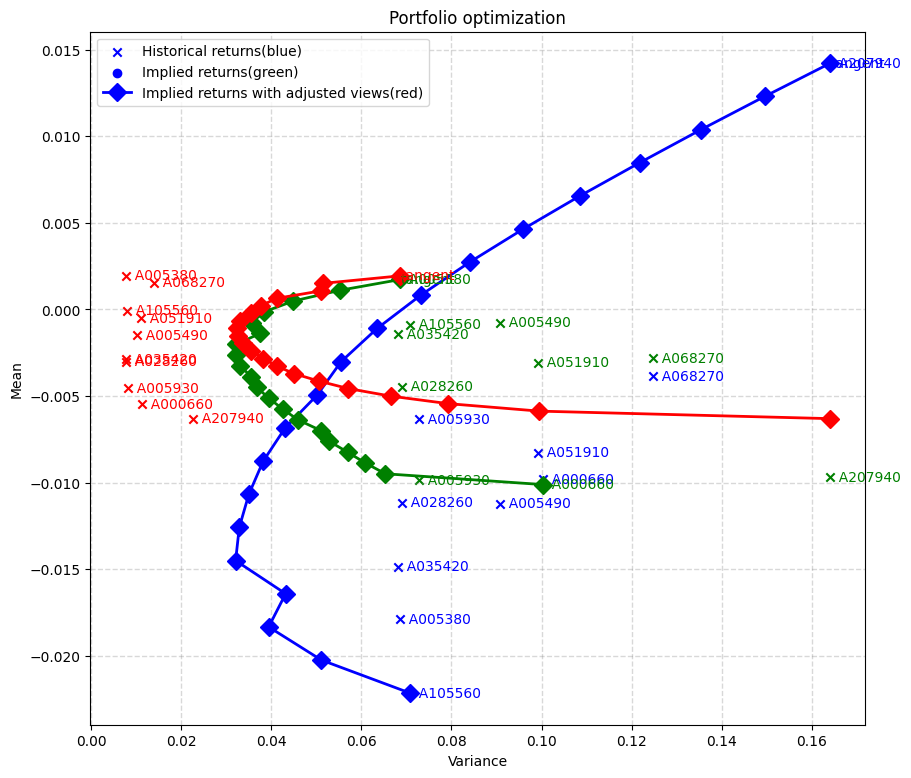

Epoch [1/10], Train Loss: 110.11312770843506, Validation Loss: 16.364213943481445
Epoch [2/10], Train Loss: 109.16647338867188, Validation Loss: 16.48453712463379
Epoch [3/10], Train Loss: 108.44957065582275, Validation Loss: 16.617496490478516
Epoch [4/10], Train Loss: 107.78448390960693, Validation Loss: 16.745708465576172
Epoch [5/10], Train Loss: 107.33369827270508, Validation Loss: 16.866634368896484
Epoch [6/10], Train Loss: 106.62474536895752, Validation Loss: 16.977519989013672
Epoch [7/10], Train Loss: 105.85726261138916, Validation Loss: 17.069799423217773
Epoch [8/10], Train Loss: 105.35095405578613, Validation Loss: 17.129667282104492
Epoch [9/10], Train Loss: 104.37176275253296, Validation Loss: 17.159093856811523
Epoch [10/10], Train Loss: 103.88324785232544, Validation Loss: 17.142358779907227
Epoch [1/10], Train Loss: 119.62314891815186, Validation Loss: 23.962499618530273
Epoch [2/10], Train Loss: 118.79226493835449, Validation Loss: 23.895063400268555
Epoch [3/10], Tr

/tmp/ipykernel_2819358/393526100.py:80: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


2018-10-29 00:00:00,A005930,A000660,A068270,A207940,A051910,A005490,A005380,A017670,A105560,A055550
Weight,4.97%,4.97%,4.97%,4.97%,4.97%,4.97%,4.97%,55.28%,4.97%,4.97%


2018-10-29 00:00:00,A005930,A000660,A068270,A207940,A051910,A005490,A005380,A017670,A105560,A055550
Weight,0.00%,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


2018-10-29 00:00:00,A005930,A000660,A068270,A207940,A051910,A005490,A005380,A017670,A105560,A055550
Weight,0.00%,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


/tmp/ipykernel_2819358/2353691125.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color)


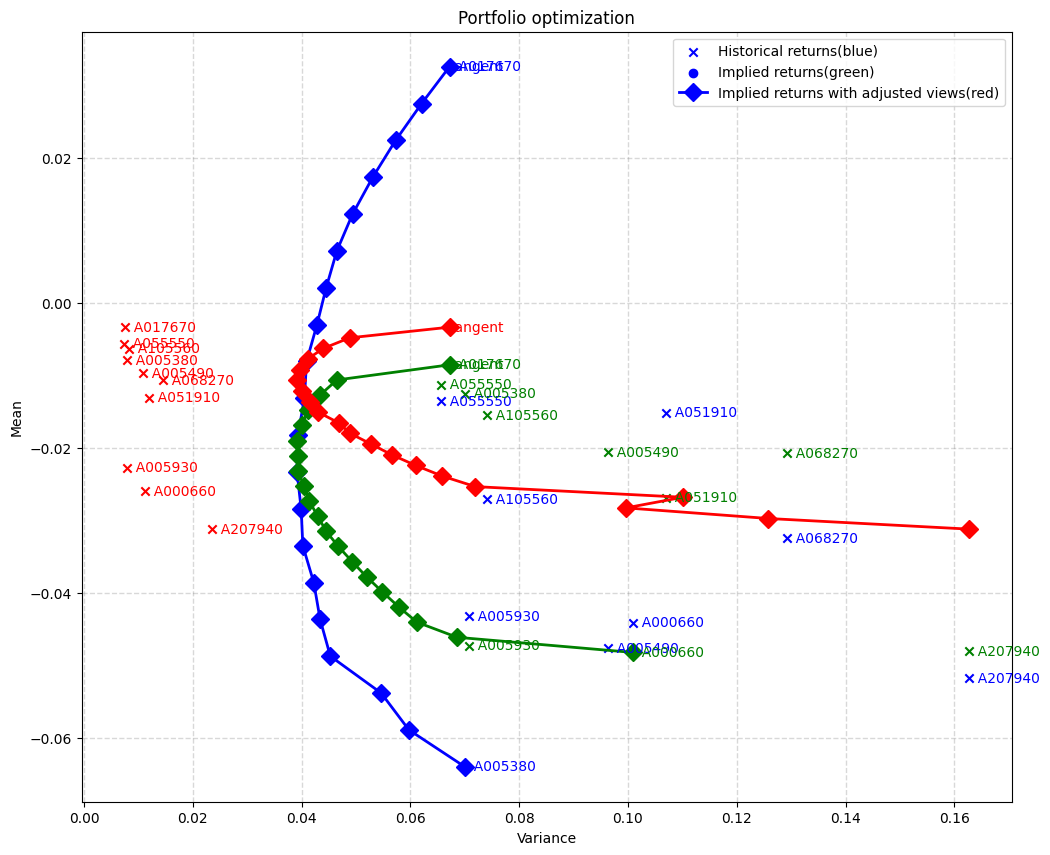

Epoch [1/10], Train Loss: 113.35891628265381, Validation Loss: 17.206684112548828
Epoch [2/10], Train Loss: 112.40797328948975, Validation Loss: 17.0689697265625
Epoch [3/10], Train Loss: 111.92112159729004, Validation Loss: 16.96221160888672
Epoch [4/10], Train Loss: 111.49251079559326, Validation Loss: 16.866796493530273
Epoch [5/10], Train Loss: 110.98414421081543, Validation Loss: 16.774335861206055
Epoch [6/10], Train Loss: 110.52993965148926, Validation Loss: 16.680105209350586
Epoch [7/10], Train Loss: 109.97582912445068, Validation Loss: 16.592222213745117
Epoch [8/10], Train Loss: 109.31907653808594, Validation Loss: 16.502784729003906
Epoch [9/10], Train Loss: 108.71956253051758, Validation Loss: 16.398971557617188
Epoch [10/10], Train Loss: 107.76372146606445, Validation Loss: 16.27794075012207
Epoch [1/10], Train Loss: 115.78806972503662, Validation Loss: 21.087520599365234
Epoch [2/10], Train Loss: 114.9778938293457, Validation Loss: 21.13700294494629
Epoch [3/10], Train L

/tmp/ipykernel_2819358/393526100.py:80: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


2018-11-26 00:00:00,A005930,A000660,A068270,A051910,A017670,A207940,A005490,A035420,A005380,A055550
Weight,5.89%,5.89%,5.89%,5.92%,46.97%,5.89%,5.89%,5.89%,5.89%,5.89%


2018-11-26 00:00:00,A005930,A000660,A068270,A051910,A017670,A207940,A005490,A035420,A005380,A055550
Weight,0.00%,0.00%,0.00%,0.00%,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%


2018-11-26 00:00:00,A005930,A000660,A068270,A051910,A017670,A207940,A005490,A035420,A005380,A055550
Weight,0.00%,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


/tmp/ipykernel_2819358/2353691125.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color)


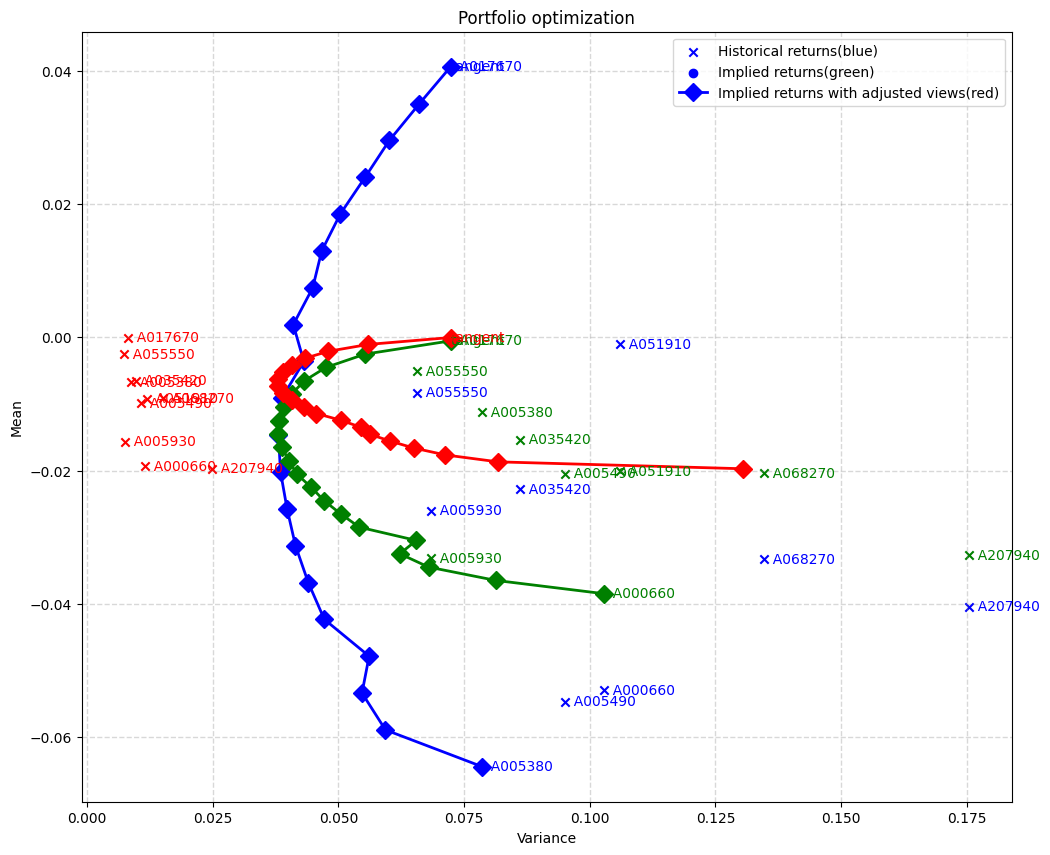

Epoch [1/10], Train Loss: 116.02999591827393, Validation Loss: 20.774639129638672
Epoch [2/10], Train Loss: 114.42979049682617, Validation Loss: 20.310630798339844
Epoch [3/10], Train Loss: 113.38963794708252, Validation Loss: 19.928329467773438
Epoch [4/10], Train Loss: 112.37675952911377, Validation Loss: 19.605640411376953
Epoch [5/10], Train Loss: 111.81085014343262, Validation Loss: 19.332656860351562
Epoch [6/10], Train Loss: 111.17418956756592, Validation Loss: 19.103954315185547
Epoch [7/10], Train Loss: 110.2500696182251, Validation Loss: 18.91017723083496
Epoch [8/10], Train Loss: 109.73996543884277, Validation Loss: 18.740537643432617
Epoch [9/10], Train Loss: 108.98390197753906, Validation Loss: 18.59137535095215
Epoch [10/10], Train Loss: 108.11492443084717, Validation Loss: 18.45831298828125
Epoch [1/10], Train Loss: 110.60876178741455, Validation Loss: 25.419050216674805
Epoch [2/10], Train Loss: 109.68691158294678, Validation Loss: 25.194236755371094
Epoch [3/10], Train

/tmp/ipykernel_2819358/393526100.py:80: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


2018-12-24 00:00:00,A005930,A000660,A068270,A005380,A051910,A207940,A017670,A005490,A015760,A105560
Weight,4.78%,4.78%,4.78%,4.78%,40.82%,4.78%,25.85%,4.78%,4.78%,4.78%


2018-12-24 00:00:00,A005930,A000660,A068270,A005380,A051910,A207940,A017670,A005490,A015760,A105560
Weight,0.00%,0.00%,0.00%,0.03%,0.00%,5.45%,94.55%,0.00%,0.08%,0.05%


2018-12-24 00:00:00,A005930,A000660,A068270,A005380,A051910,A207940,A017670,A005490,A015760,A105560
Weight,0.03%,0.05%,3.43%,0.00%,0.01%,0.04%,96.52%,0.01%,0.00%,0.00%


/tmp/ipykernel_2819358/2353691125.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color)


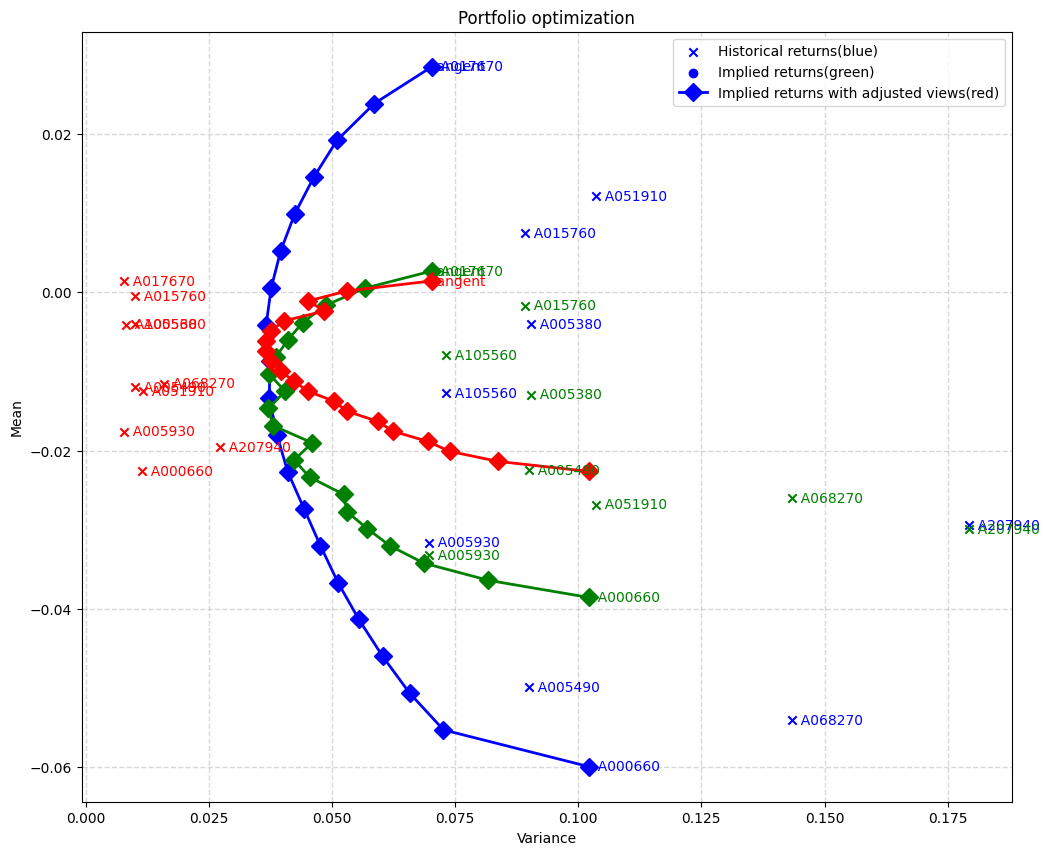

Epoch [1/10], Train Loss: 113.5904130935669, Validation Loss: 22.84197998046875
Epoch [2/10], Train Loss: 112.91044425964355, Validation Loss: 22.78516387939453
Epoch [3/10], Train Loss: 112.45473861694336, Validation Loss: 22.716032028198242
Epoch [4/10], Train Loss: 112.17637920379639, Validation Loss: 22.64228057861328
Epoch [5/10], Train Loss: 111.5339241027832, Validation Loss: 22.559831619262695
Epoch [6/10], Train Loss: 111.0238265991211, Validation Loss: 22.468067169189453
Epoch [7/10], Train Loss: 110.19596576690674, Validation Loss: 22.370901107788086
Epoch [8/10], Train Loss: 109.51091766357422, Validation Loss: 22.265155792236328
Epoch [9/10], Train Loss: 108.74442481994629, Validation Loss: 22.14503288269043
Epoch [10/10], Train Loss: 107.73844242095947, Validation Loss: 22.015464782714844
Epoch [1/10], Train Loss: 108.77302742004395, Validation Loss: 23.590312957763672
Epoch [2/10], Train Loss: 108.28397750854492, Validation Loss: 23.49207878112793
Epoch [3/10], Train Los

/tmp/ipykernel_2819358/393526100.py:80: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


2019-01-24 00:00:00,A005930,A000660,A005380,A068270,A207940,A051910,A005490,A028260,A017670,A035420
Weight,0.00%,0.00%,0.00%,0.00%,8.83%,0.00%,0.00%,0.00%,91.17%,0.00%


2019-01-24 00:00:00,A005930,A000660,A005380,A068270,A207940,A051910,A005490,A028260,A017670,A035420
Weight,0.00%,0.00%,0.01%,0.00%,14.78%,0.00%,0.00%,0.00%,85.21%,0.00%


2019-01-24 00:00:00,A005930,A000660,A005380,A068270,A207940,A051910,A005490,A028260,A017670,A035420
Weight,0.01%,0.01%,12.66%,13.52%,0.01%,0.00%,0.02%,0.00%,73.81%,0.00%


/tmp/ipykernel_2819358/2353691125.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color)


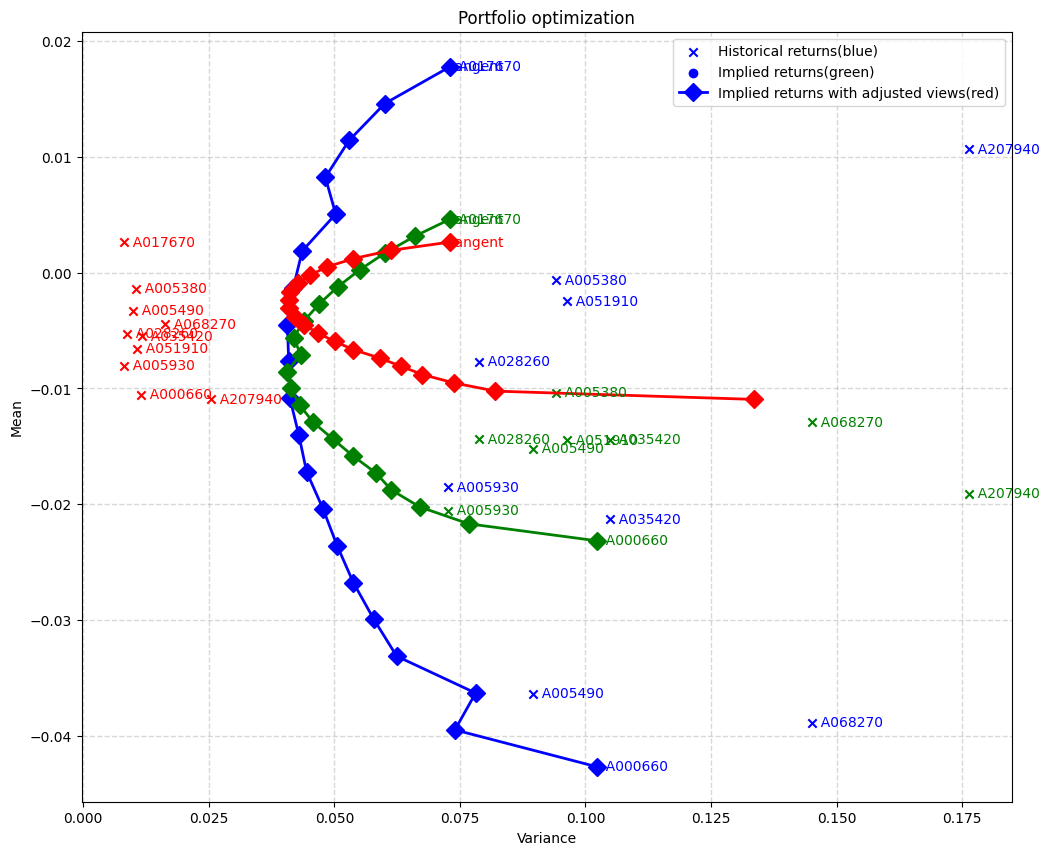

Epoch [1/10], Train Loss: 113.18456935882568, Validation Loss: 22.498796463012695
Epoch [2/10], Train Loss: 112.28810977935791, Validation Loss: 22.37272834777832
Epoch [3/10], Train Loss: 111.39875221252441, Validation Loss: 22.26297378540039
Epoch [4/10], Train Loss: 110.80323219299316, Validation Loss: 22.157194137573242
Epoch [5/10], Train Loss: 110.17550468444824, Validation Loss: 22.048078536987305
Epoch [6/10], Train Loss: 109.47118186950684, Validation Loss: 21.930822372436523
Epoch [7/10], Train Loss: 108.86910724639893, Validation Loss: 21.802391052246094
Epoch [8/10], Train Loss: 108.25829601287842, Validation Loss: 21.657339096069336
Epoch [9/10], Train Loss: 107.41448020935059, Validation Loss: 21.48467445373535
Epoch [10/10], Train Loss: 106.58243751525879, Validation Loss: 21.280126571655273
Epoch [1/10], Train Loss: 106.20575523376465, Validation Loss: 23.95441246032715
Epoch [2/10], Train Loss: 105.56065559387207, Validation Loss: 23.890783309936523
Epoch [3/10], Train

/tmp/ipykernel_2819358/393526100.py:80: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


2019-02-26 00:00:00,A005930,A000660,A051910,A005380,A068270,A207940,A005490,A015760,A028260,A035420
Weight,5.10%,4.83%,7.57%,4.99%,4.84%,4.83%,4.83%,54.06%,4.92%,4.83%


2019-02-26 00:00:00,A005930,A000660,A051910,A005380,A068270,A207940,A005490,A015760,A028260,A035420
Weight,0.00%,0.00%,0.00%,0.00%,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%


2019-02-26 00:00:00,A005930,A000660,A051910,A005380,A068270,A207940,A005490,A015760,A028260,A035420
Weight,1.22%,1.23%,1.22%,1.22%,88.99%,1.23%,1.22%,1.22%,1.22%,1.23%


/tmp/ipykernel_2819358/2353691125.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color)


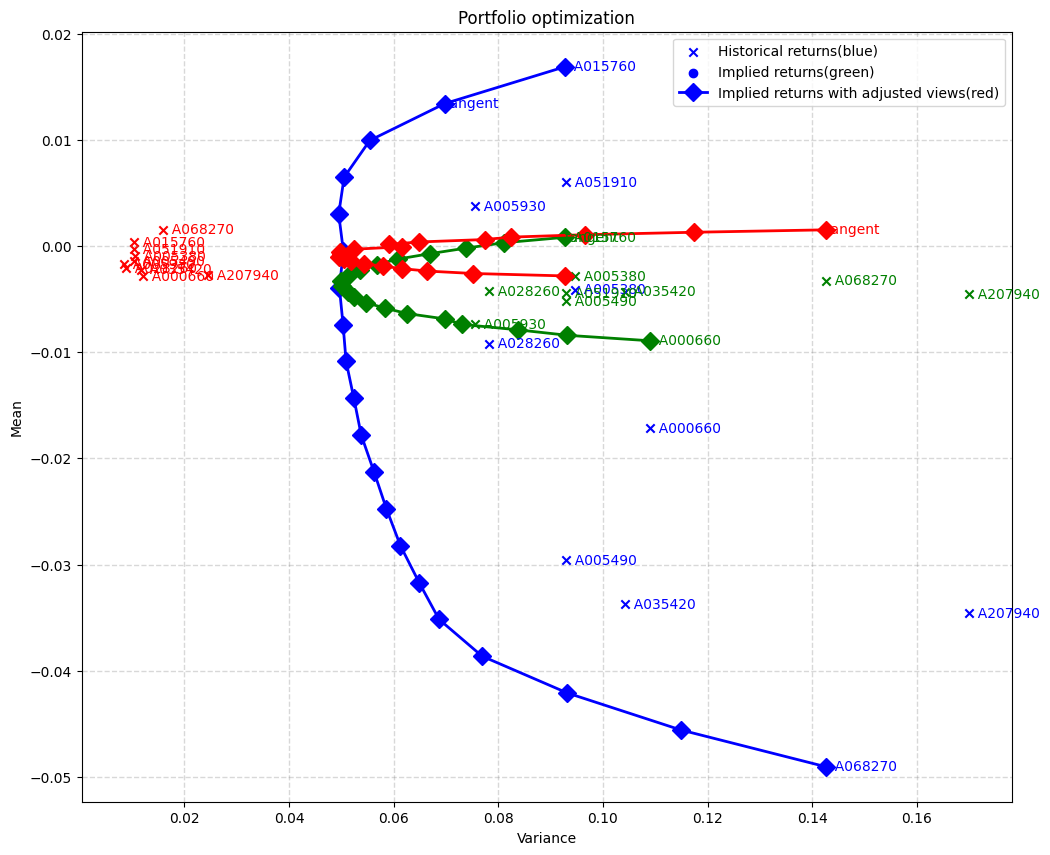

Epoch [1/10], Train Loss: 114.52272129058838, Validation Loss: 20.812129974365234
Epoch [2/10], Train Loss: 113.87649059295654, Validation Loss: 20.750511169433594
Epoch [3/10], Train Loss: 113.48563480377197, Validation Loss: 20.68724822998047
Epoch [4/10], Train Loss: 113.15710544586182, Validation Loss: 20.611421585083008
Epoch [5/10], Train Loss: 112.5212173461914, Validation Loss: 20.528383255004883
Epoch [6/10], Train Loss: 112.2133846282959, Validation Loss: 20.434701919555664
Epoch [7/10], Train Loss: 111.88713550567627, Validation Loss: 20.32695770263672
Epoch [8/10], Train Loss: 111.15939235687256, Validation Loss: 20.198211669921875
Epoch [9/10], Train Loss: 110.62581443786621, Validation Loss: 20.044231414794922
Epoch [10/10], Train Loss: 109.93884468078613, Validation Loss: 19.857210159301758
Epoch [1/10], Train Loss: 118.2111120223999, Validation Loss: 24.794816970825195
Epoch [2/10], Train Loss: 117.47851085662842, Validation Loss: 24.6807804107666
Epoch [3/10], Train Lo

/tmp/ipykernel_2819358/393526100.py:80: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


2019-03-27 00:00:00,A005930,A000660,A051910,A005380,A068270,A005490,A051900,A207940,A028260,A017670
Weight,3.98%,3.98%,3.98%,3.98%,3.98%,3.98%,64.15%,3.98%,3.98%,3.98%


2019-03-27 00:00:00,A005930,A000660,A051910,A005380,A068270,A005490,A051900,A207940,A028260,A017670
Weight,0.01%,0.02%,0.00%,0.05%,0.07%,0.00%,0.00%,15.35%,0.03%,84.66%


2019-03-27 00:00:00,A005930,A000660,A051910,A005380,A068270,A005490,A051900,A207940,A028260,A017670
Weight,0.00%,0.00%,0.00%,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%


/tmp/ipykernel_2819358/2353691125.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color)


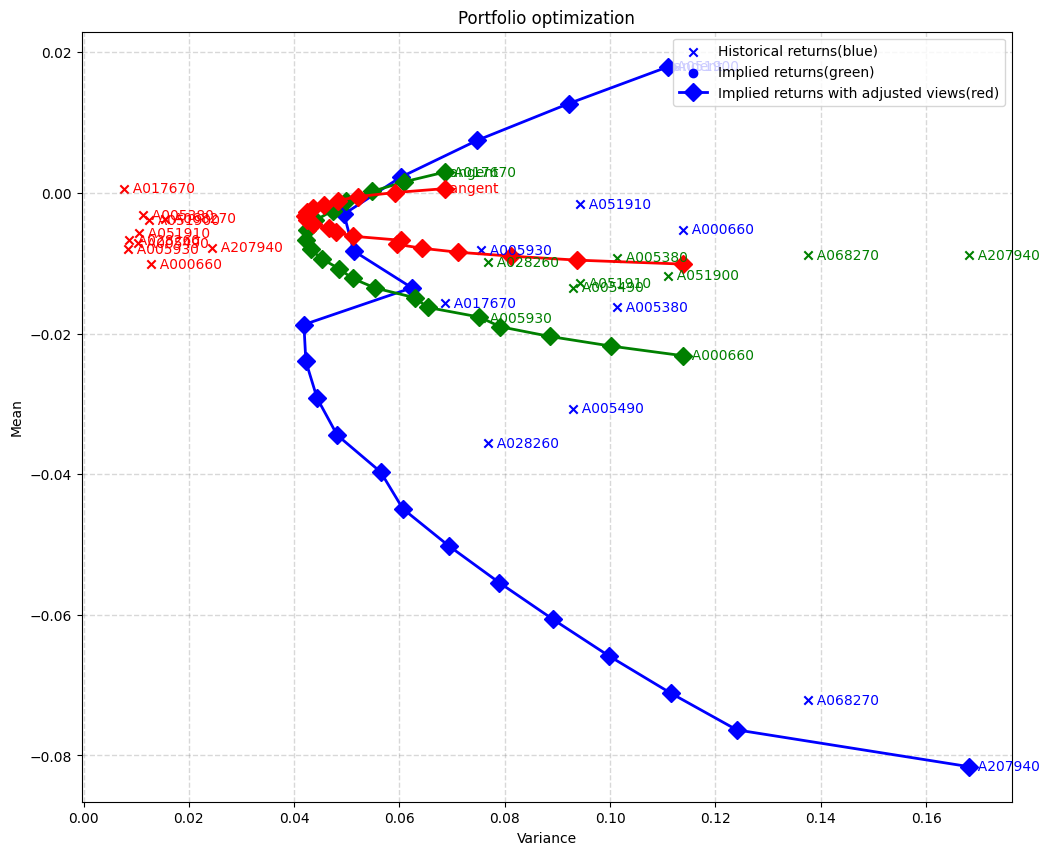

Epoch [1/10], Train Loss: 111.84198904037476, Validation Loss: 18.666852951049805
Epoch [2/10], Train Loss: 110.99354028701782, Validation Loss: 18.537555694580078
Epoch [3/10], Train Loss: 110.3602967262268, Validation Loss: 18.423484802246094
Epoch [4/10], Train Loss: 110.00325345993042, Validation Loss: 18.314876556396484
Epoch [5/10], Train Loss: 109.48316955566406, Validation Loss: 18.206911087036133
Epoch [6/10], Train Loss: 109.16061210632324, Validation Loss: 18.09984588623047
Epoch [7/10], Train Loss: 108.50066375732422, Validation Loss: 17.989469528198242
Epoch [8/10], Train Loss: 108.02467918395996, Validation Loss: 17.868011474609375
Epoch [9/10], Train Loss: 107.46295404434204, Validation Loss: 17.736330032348633
Epoch [10/10], Train Loss: 106.67357063293457, Validation Loss: 17.588665008544922
Epoch [1/10], Train Loss: 118.17780590057373, Validation Loss: 26.025850296020508
Epoch [2/10], Train Loss: 117.15155982971191, Validation Loss: 25.92344856262207
Epoch [3/10], Trai

/tmp/ipykernel_2819358/393526100.py:80: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


2019-04-24 00:00:00,A005930,A000660,A005380,A068270,A051910,A207940,A012330,A005490,A051900,A028260
Weight,0.00%,9.14%,28.86%,0.00%,2.76%,0.00%,4.18%,0.00%,55.05%,0.00%


2019-04-24 00:00:00,A005930,A000660,A005380,A068270,A051910,A207940,A012330,A005490,A051900,A028260
Weight,51.38%,10.99%,5.70%,5.36%,4.91%,4.60%,4.35%,4.34%,4.33%,4.05%


2019-04-24 00:00:00,A005930,A000660,A005380,A068270,A051910,A207940,A012330,A005490,A051900,A028260
Weight,34.70%,20.23%,11.08%,8.48%,10.33%,6.22%,3.04%,0.00%,5.91%,0.00%


/tmp/ipykernel_2819358/2353691125.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color)


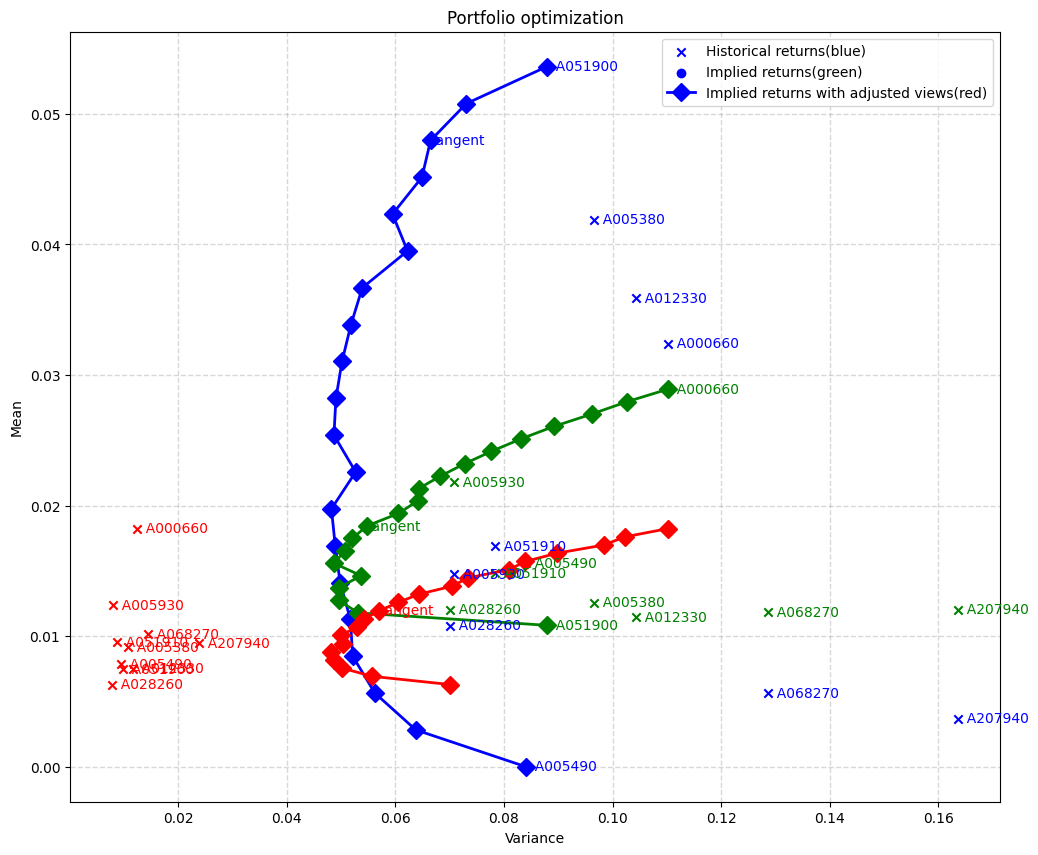

Epoch [1/10], Train Loss: 108.04688549041748, Validation Loss: 19.65484619140625
Epoch [2/10], Train Loss: 107.5138578414917, Validation Loss: 19.61236000061035
Epoch [3/10], Train Loss: 107.11765480041504, Validation Loss: 19.577512741088867
Epoch [4/10], Train Loss: 106.61534690856934, Validation Loss: 19.543081283569336
Epoch [5/10], Train Loss: 106.30606079101562, Validation Loss: 19.506893157958984
Epoch [6/10], Train Loss: 106.0796308517456, Validation Loss: 19.466623306274414
Epoch [7/10], Train Loss: 105.68937397003174, Validation Loss: 19.420928955078125
Epoch [8/10], Train Loss: 105.37318801879883, Validation Loss: 19.368505477905273
Epoch [9/10], Train Loss: 104.8542833328247, Validation Loss: 19.310447692871094
Epoch [10/10], Train Loss: 104.15961265563965, Validation Loss: 19.236663818359375
Epoch [1/10], Train Loss: 117.31774234771729, Validation Loss: 26.428607940673828
Epoch [2/10], Train Loss: 116.37039852142334, Validation Loss: 26.292922973632812
Epoch [3/10], Train 

/tmp/ipykernel_2819358/393526100.py:80: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


2019-05-24 00:00:00,A005930,A000660,A005380,A068270,A051910,A055550,A017670,A012330,A005490,A051900
Weight,0.00%,0.00%,53.57%,0.00%,0.00%,22.49%,0.00%,0.00%,0.00%,23.94%


2019-05-24 00:00:00,A005930,A000660,A005380,A068270,A051910,A055550,A017670,A012330,A005490,A051900
Weight,53.01%,10.23%,5.80%,4.83%,4.78%,4.62%,4.25%,4.24%,4.15%,4.09%


2019-05-24 00:00:00,A005930,A000660,A005380,A068270,A051910,A055550,A017670,A012330,A005490,A051900
Weight,18.65%,9.04%,9.04%,9.04%,9.04%,9.04%,9.04%,9.04%,9.04%,9.04%


/tmp/ipykernel_2819358/2353691125.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color)


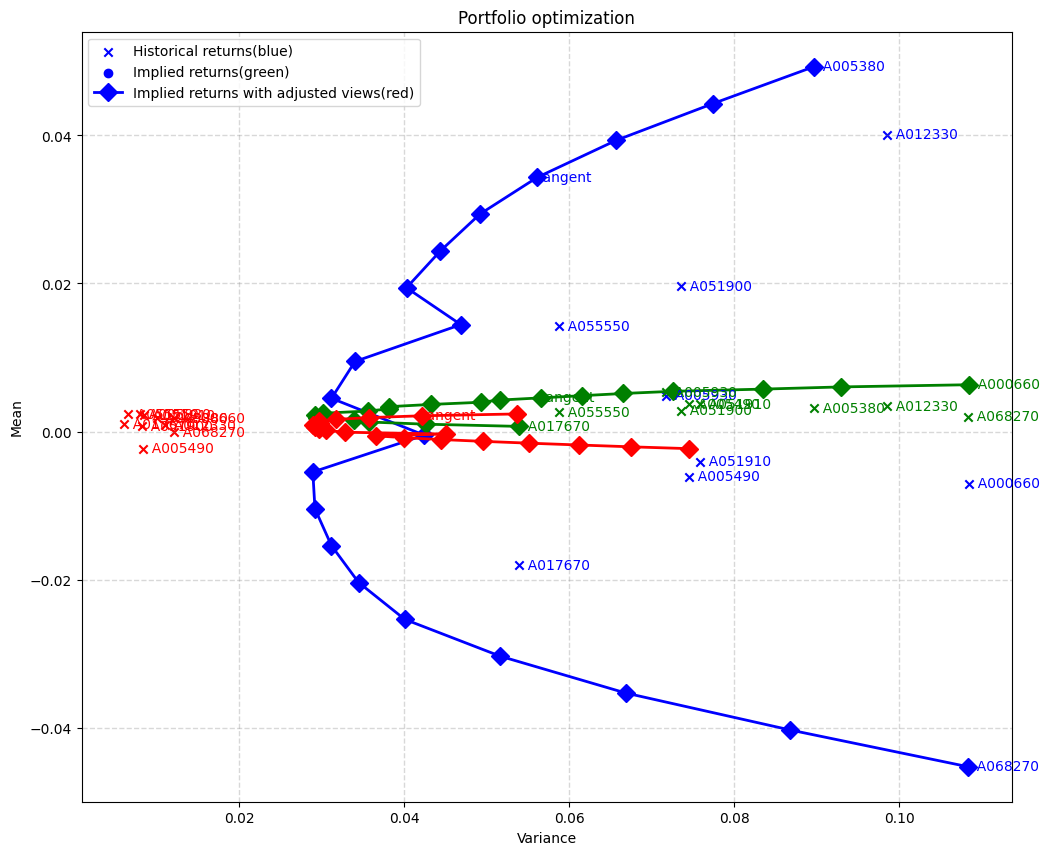

Epoch [1/10], Train Loss: 112.41952228546143, Validation Loss: 17.803272247314453
Epoch [2/10], Train Loss: 111.68734550476074, Validation Loss: 17.737600326538086
Epoch [3/10], Train Loss: 111.00109481811523, Validation Loss: 17.6707820892334
Epoch [4/10], Train Loss: 110.21822547912598, Validation Loss: 17.605588912963867
Epoch [5/10], Train Loss: 109.84022521972656, Validation Loss: 17.529653549194336
Epoch [6/10], Train Loss: 109.29782104492188, Validation Loss: 17.441225051879883
Epoch [7/10], Train Loss: 108.5507583618164, Validation Loss: 17.331130981445312
Epoch [8/10], Train Loss: 107.99343204498291, Validation Loss: 17.18792152404785
Epoch [9/10], Train Loss: 106.76181411743164, Validation Loss: 17.003095626831055
Epoch [10/10], Train Loss: 105.74374008178711, Validation Loss: 16.767810821533203
Epoch [1/10], Train Loss: 116.69760131835938, Validation Loss: 24.162654876708984
Epoch [2/10], Train Loss: 115.86829471588135, Validation Loss: 23.99714469909668
Epoch [3/10], Train 

/tmp/ipykernel_2819358/393526100.py:80: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


2019-06-24 00:00:00,A005930,A000660,A005380,A068270,A051910,A012330,A005490,A207940,A055550,A017670
Weight,53.54%,0.00%,19.61%,6.81%,0.00%,8.82%,0.00%,0.00%,11.22%,0.00%


2019-06-24 00:00:00,A005930,A000660,A005380,A068270,A051910,A012330,A005490,A207940,A055550,A017670
Weight,53.38%,9.57%,5.99%,5.26%,4.84%,4.29%,4.19%,4.18%,4.18%,4.12%


2019-06-24 00:00:00,A005930,A000660,A005380,A068270,A051910,A012330,A005490,A207940,A055550,A017670
Weight,45.66%,4.95%,9.53%,5.34%,7.31%,0.00%,6.37%,6.07%,0.00%,14.77%


/tmp/ipykernel_2819358/2353691125.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color)


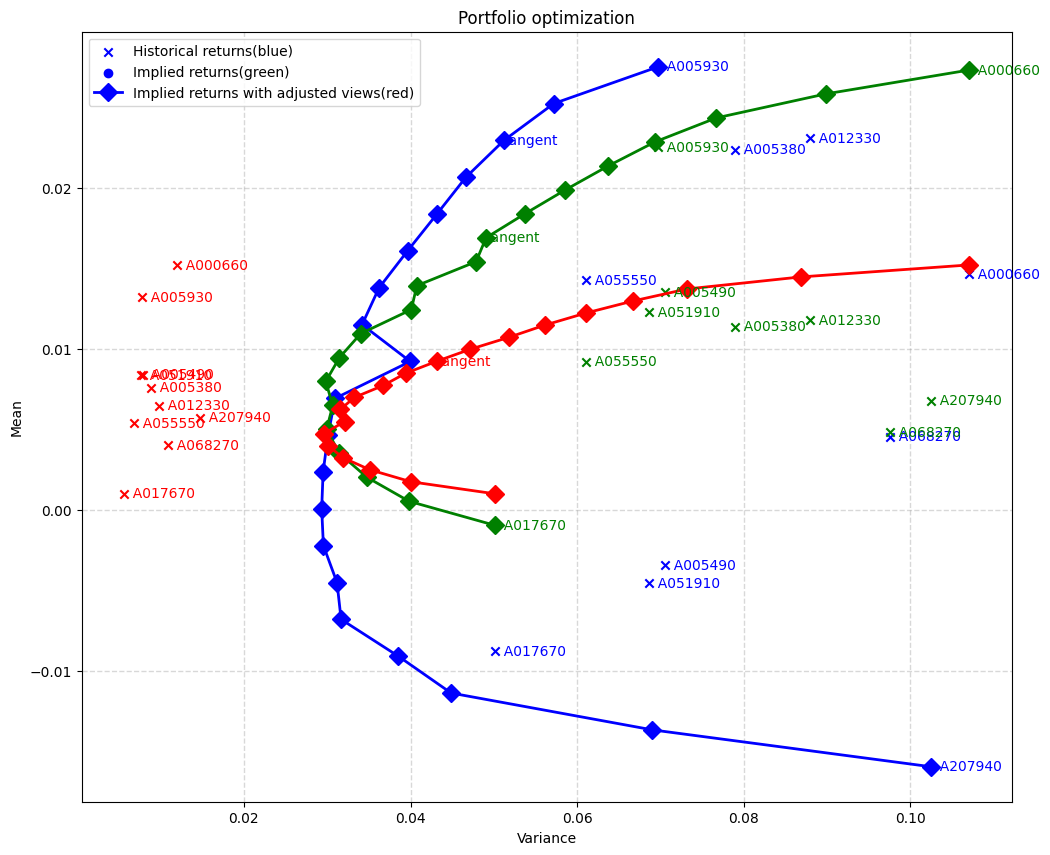

Epoch [1/10], Train Loss: 108.65799331665039, Validation Loss: 12.025928497314453
Epoch [2/10], Train Loss: 107.91790866851807, Validation Loss: 11.993733406066895
Epoch [3/10], Train Loss: 107.35032844543457, Validation Loss: 11.961012840270996
Epoch [4/10], Train Loss: 106.83973217010498, Validation Loss: 11.924030303955078
Epoch [5/10], Train Loss: 106.28013706207275, Validation Loss: 11.883519172668457
Epoch [6/10], Train Loss: 105.59172248840332, Validation Loss: 11.839967727661133
Epoch [7/10], Train Loss: 105.13274765014648, Validation Loss: 11.788420677185059
Epoch [8/10], Train Loss: 104.26977729797363, Validation Loss: 11.726754188537598
Epoch [9/10], Train Loss: 103.44566535949707, Validation Loss: 11.65372371673584
Epoch [10/10], Train Loss: 102.65988349914551, Validation Loss: 11.56831169128418
Epoch [1/10], Train Loss: 119.10713768005371, Validation Loss: 21.85711669921875
Epoch [2/10], Train Loss: 118.36453342437744, Validation Loss: 21.746484756469727
Epoch [3/10], Trai

/tmp/ipykernel_2819358/393526100.py:80: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


2019-07-22 00:00:00,A005930,A000660,A005380,A051910,A068270,A012330,A055550,A017670,A005490,A051900
Weight,1.82%,0.70%,0.00%,0.00%,0.00%,16.00%,39.10%,0.00%,0.00%,42.38%


2019-07-22 00:00:00,A005930,A000660,A005380,A051910,A068270,A012330,A055550,A017670,A005490,A051900
Weight,54.06%,10.95%,5.45%,4.84%,4.54%,4.16%,4.14%,3.98%,3.95%,3.93%


2019-07-22 00:00:00,A005930,A000660,A005380,A051910,A068270,A012330,A055550,A017670,A005490,A051900
Weight,25.75%,16.89%,0.00%,16.36%,0.00%,3.98%,23.15%,13.87%,0.00%,0.00%


/tmp/ipykernel_2819358/2353691125.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color)


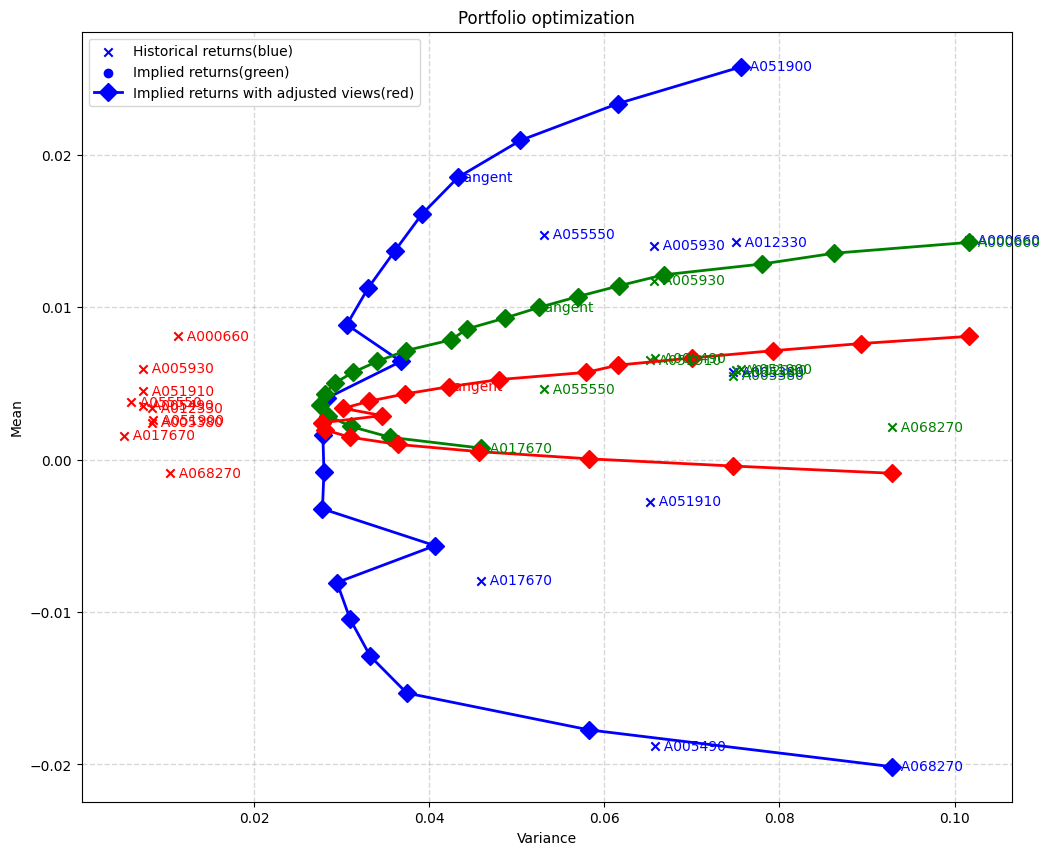

Epoch [1/10], Train Loss: 107.13234329223633, Validation Loss: 13.572493553161621
Epoch [2/10], Train Loss: 106.41324234008789, Validation Loss: 13.459527015686035
Epoch [3/10], Train Loss: 105.87557220458984, Validation Loss: 13.353813171386719
Epoch [4/10], Train Loss: 105.32705020904541, Validation Loss: 13.257903099060059
Epoch [5/10], Train Loss: 104.88401985168457, Validation Loss: 13.170005798339844
Epoch [6/10], Train Loss: 104.34275245666504, Validation Loss: 13.086106300354004
Epoch [7/10], Train Loss: 104.01569938659668, Validation Loss: 12.998379707336426
Epoch [8/10], Train Loss: 103.6279993057251, Validation Loss: 12.90816593170166
Epoch [9/10], Train Loss: 102.92952156066895, Validation Loss: 12.812883377075195
Epoch [10/10], Train Loss: 102.32693099975586, Validation Loss: 12.707205772399902
Epoch [1/10], Train Loss: 122.0485897064209, Validation Loss: 19.416400909423828
Epoch [2/10], Train Loss: 121.46655464172363, Validation Loss: 19.383155822753906
Epoch [3/10], Trai

/tmp/ipykernel_2819358/393526100.py:80: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


2019-08-20 00:00:00,A005930,A000660,A005380,A035420,A012330,A051910,A068270,A055550,A017670,A207940
Weight,5.99%,5.97%,5.97%,5.97%,46.08%,6.01%,6.03%,5.98%,5.99%,6.02%


2019-08-20 00:00:00,A005930,A000660,A005380,A035420,A012330,A051910,A068270,A055550,A017670,A207940
Weight,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,100.00%,0.00%,0.00%,0.00%


2019-08-20 00:00:00,A005930,A000660,A005380,A035420,A012330,A051910,A068270,A055550,A017670,A207940
Weight,0.09%,0.12%,0.06%,25.04%,0.05%,0.05%,0.07%,0.04%,74.42%,0.07%


/tmp/ipykernel_2819358/2353691125.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color)


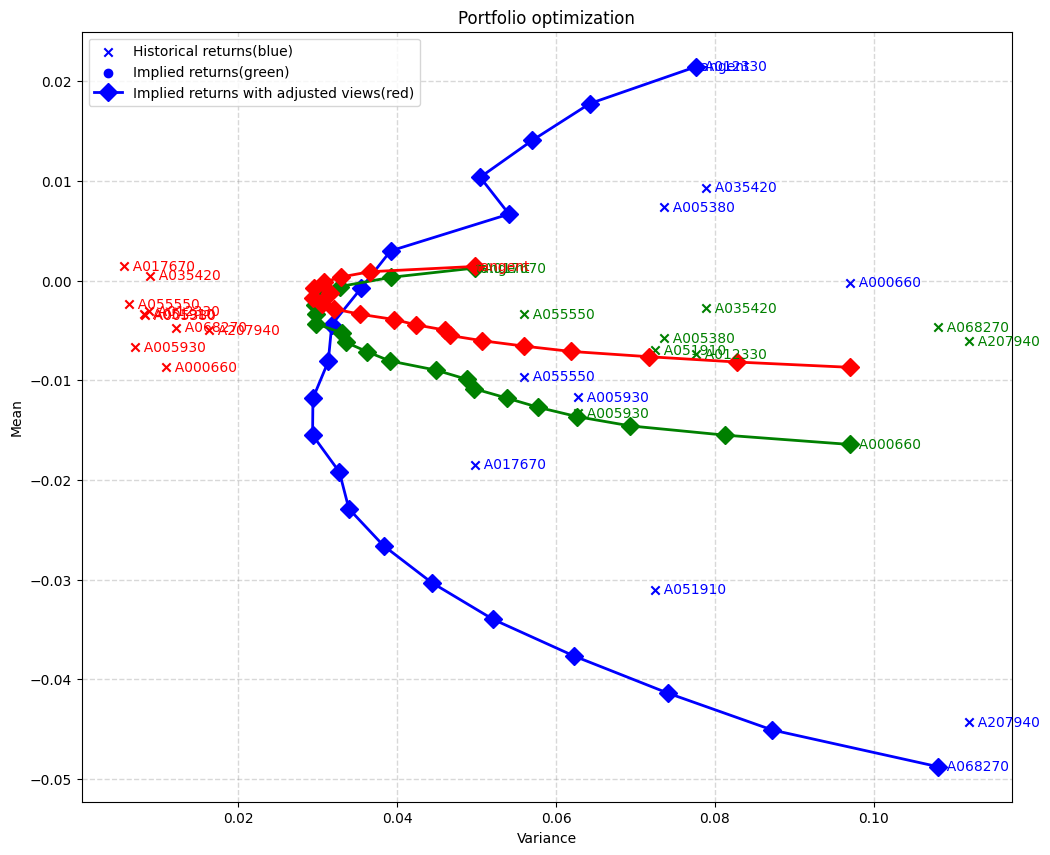

Epoch [1/10], Train Loss: 112.32245540618896, Validation Loss: 15.061188697814941
Epoch [2/10], Train Loss: 111.56061172485352, Validation Loss: 14.997579574584961
Epoch [3/10], Train Loss: 111.19579124450684, Validation Loss: 14.937451362609863
Epoch [4/10], Train Loss: 110.70312118530273, Validation Loss: 14.87935733795166
Epoch [5/10], Train Loss: 110.43468379974365, Validation Loss: 14.825809478759766
Epoch [6/10], Train Loss: 109.92675018310547, Validation Loss: 14.773521423339844
Epoch [7/10], Train Loss: 109.3979024887085, Validation Loss: 14.71418571472168
Epoch [8/10], Train Loss: 108.7302770614624, Validation Loss: 14.644495964050293
Epoch [9/10], Train Loss: 108.21578788757324, Validation Loss: 14.566449165344238
Epoch [10/10], Train Loss: 107.04931545257568, Validation Loss: 14.472396850585938
Epoch [1/10], Train Loss: 125.52437496185303, Validation Loss: 19.076427459716797
Epoch [2/10], Train Loss: 124.46657943725586, Validation Loss: 18.983299255371094
Epoch [3/10], Train

/tmp/ipykernel_2819358/393526100.py:80: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


2019-09-19 00:00:00,A005930,A000660,A005380,A035420,A012330,A051910,A207940,A068270,A005490,A055550
Weight,0.00%,0.00%,0.00%,59.52%,40.48%,0.00%,0.00%,0.00%,0.00%,0.00%


2019-09-19 00:00:00,A005930,A000660,A005380,A035420,A012330,A051910,A207940,A068270,A005490,A055550
Weight,54.60%,11.20%,5.13%,4.83%,4.35%,4.30%,4.05%,4.02%,3.79%,3.73%


2019-09-19 00:00:00,A005930,A000660,A005380,A035420,A012330,A051910,A207940,A068270,A005490,A055550
Weight,34.13%,4.72%,0.00%,2.94%,0.00%,0.00%,5.47%,0.72%,52.01%,0.00%


/tmp/ipykernel_2819358/2353691125.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color)


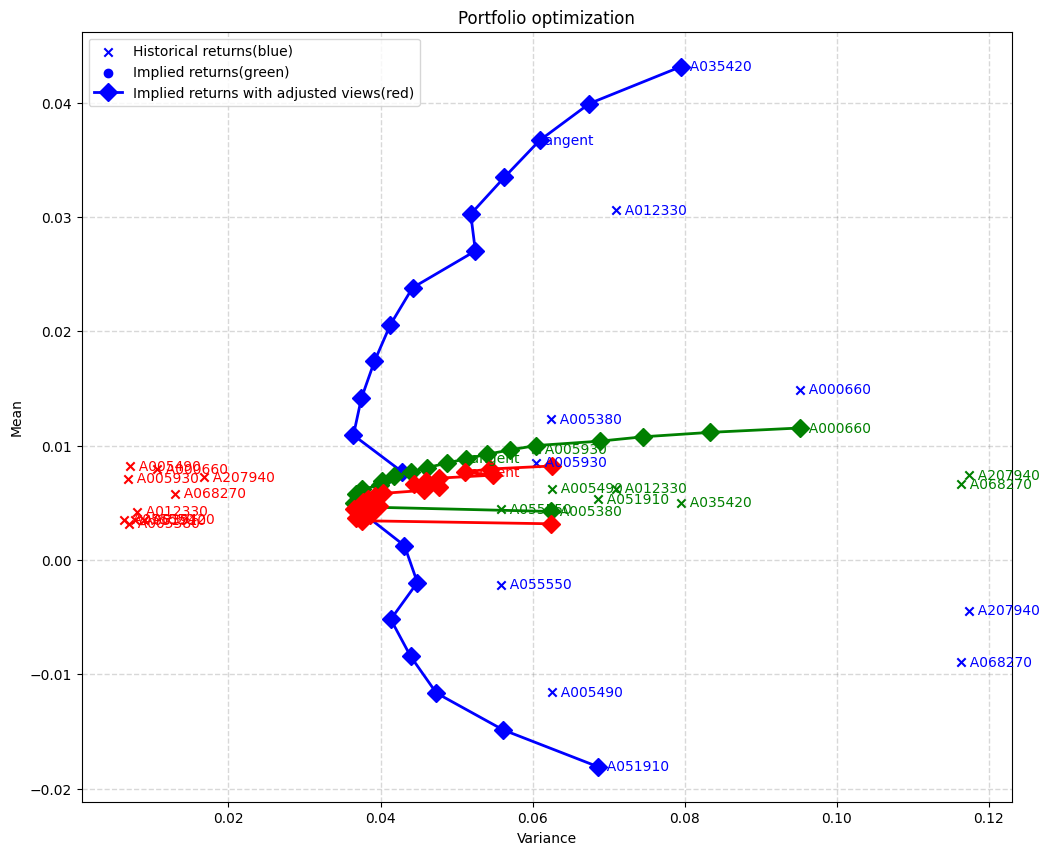

Epoch [1/10], Train Loss: 119.09447860717773, Validation Loss: 13.54317569732666
Epoch [2/10], Train Loss: 118.25953960418701, Validation Loss: 13.491667747497559
Epoch [3/10], Train Loss: 117.84191513061523, Validation Loss: 13.44803524017334
Epoch [4/10], Train Loss: 117.32919120788574, Validation Loss: 13.403438568115234
Epoch [5/10], Train Loss: 116.85313129425049, Validation Loss: 13.35152530670166
Epoch [6/10], Train Loss: 116.28139400482178, Validation Loss: 13.289902687072754
Epoch [7/10], Train Loss: 115.6034803390503, Validation Loss: 13.213492393493652
Epoch [8/10], Train Loss: 115.24867916107178, Validation Loss: 13.128612518310547
Epoch [9/10], Train Loss: 114.35284233093262, Validation Loss: 13.030080795288086
Epoch [10/10], Train Loss: 113.54128742218018, Validation Loss: 12.913604736328125
Epoch [1/10], Train Loss: 122.99947929382324, Validation Loss: 18.309528350830078
Epoch [2/10], Train Loss: 121.88869857788086, Validation Loss: 18.183364868164062
Epoch [3/10], Train

/tmp/ipykernel_2819358/393526100.py:80: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


2019-10-21 00:00:00,A005930,A000660,A005380,A035420,A068270,A012330,A207940,A051910,A055550,A051900
Weight,8.24%,8.24%,8.26%,25.77%,8.27%,8.24%,8.24%,8.27%,8.24%,8.26%


2019-10-21 00:00:00,A005930,A000660,A005380,A035420,A068270,A012330,A207940,A051910,A055550,A051900
Weight,55.87%,10.50%,4.86%,4.66%,4.34%,4.23%,4.18%,3.92%,3.78%,3.65%


2019-10-21 00:00:00,A005930,A000660,A005380,A035420,A068270,A012330,A207940,A051910,A055550,A051900
Weight,67.65%,0.00%,0.00%,0.00%,12.03%,0.00%,6.65%,0.00%,13.68%,0.00%


/tmp/ipykernel_2819358/2353691125.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color)


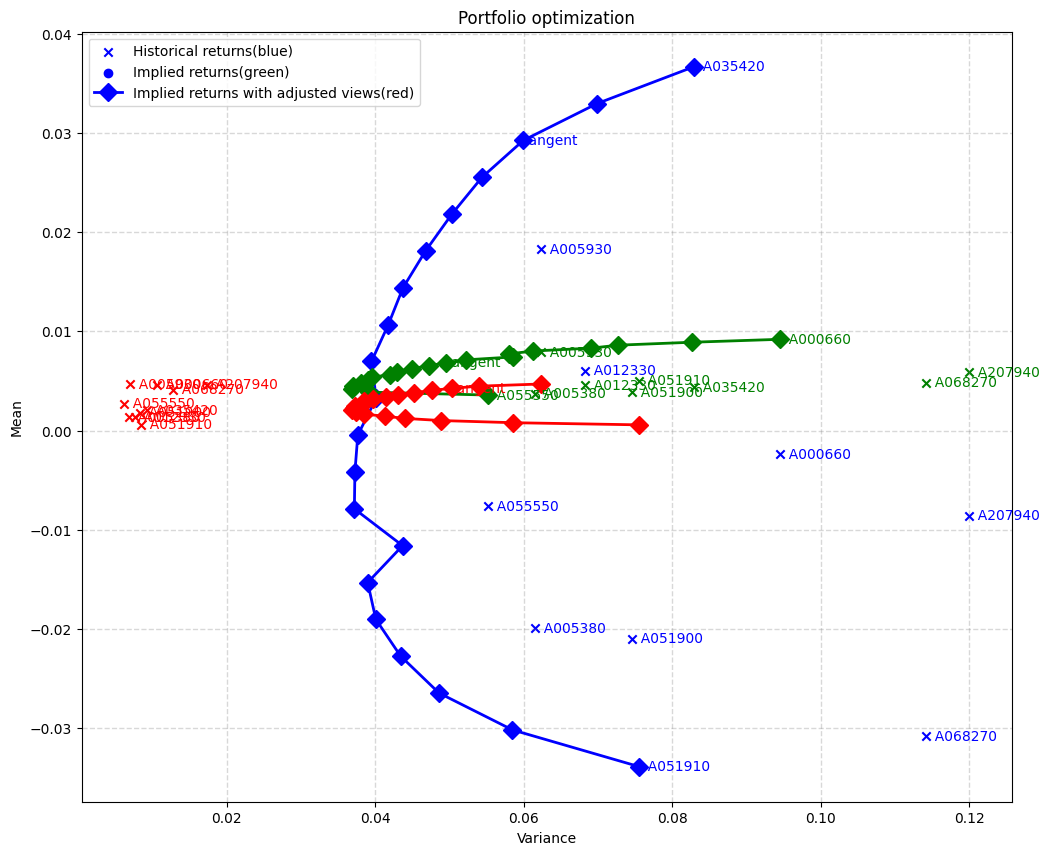

Epoch [1/10], Train Loss: 118.88613986968994, Validation Loss: 12.293230056762695
Epoch [2/10], Train Loss: 117.90323829650879, Validation Loss: 12.151728630065918
Epoch [3/10], Train Loss: 117.40560054779053, Validation Loss: 12.039122581481934
Epoch [4/10], Train Loss: 116.81041526794434, Validation Loss: 11.936856269836426
Epoch [5/10], Train Loss: 116.30410766601562, Validation Loss: 11.837929725646973
Epoch [6/10], Train Loss: 115.8790807723999, Validation Loss: 11.738618850708008
Epoch [7/10], Train Loss: 115.0647325515747, Validation Loss: 11.633874893188477
Epoch [8/10], Train Loss: 114.11306571960449, Validation Loss: 11.519831657409668
Epoch [9/10], Train Loss: 113.3342924118042, Validation Loss: 11.396872520446777
Epoch [10/10], Train Loss: 112.38815975189209, Validation Loss: 11.261473655700684
Epoch [1/10], Train Loss: 117.38866138458252, Validation Loss: 14.538732528686523
Epoch [2/10], Train Loss: 116.28278732299805, Validation Loss: 14.342290878295898
Epoch [3/10], Trai

/tmp/ipykernel_2819358/393526100.py:80: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


2019-11-18 00:00:00,A005930,A000660,A035420,A005380,A207940,A012330,A068270,A051910,A055550,A005490
Weight,38.99%,0.00%,28.74%,0.00%,15.99%,16.28%,0.00%,0.00%,0.00%,0.00%


2019-11-18 00:00:00,A005930,A000660,A035420,A005380,A207940,A012330,A068270,A051910,A055550,A005490
Weight,55.48%,10.80%,5.11%,4.69%,4.62%,4.22%,4.16%,3.87%,3.61%,3.44%


2019-11-18 00:00:00,A005930,A000660,A035420,A005380,A207940,A012330,A068270,A051910,A055550,A005490
Weight,59.97%,8.68%,3.66%,4.11%,8.92%,3.26%,0.94%,3.37%,2.79%,4.29%


/tmp/ipykernel_2819358/2353691125.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color)


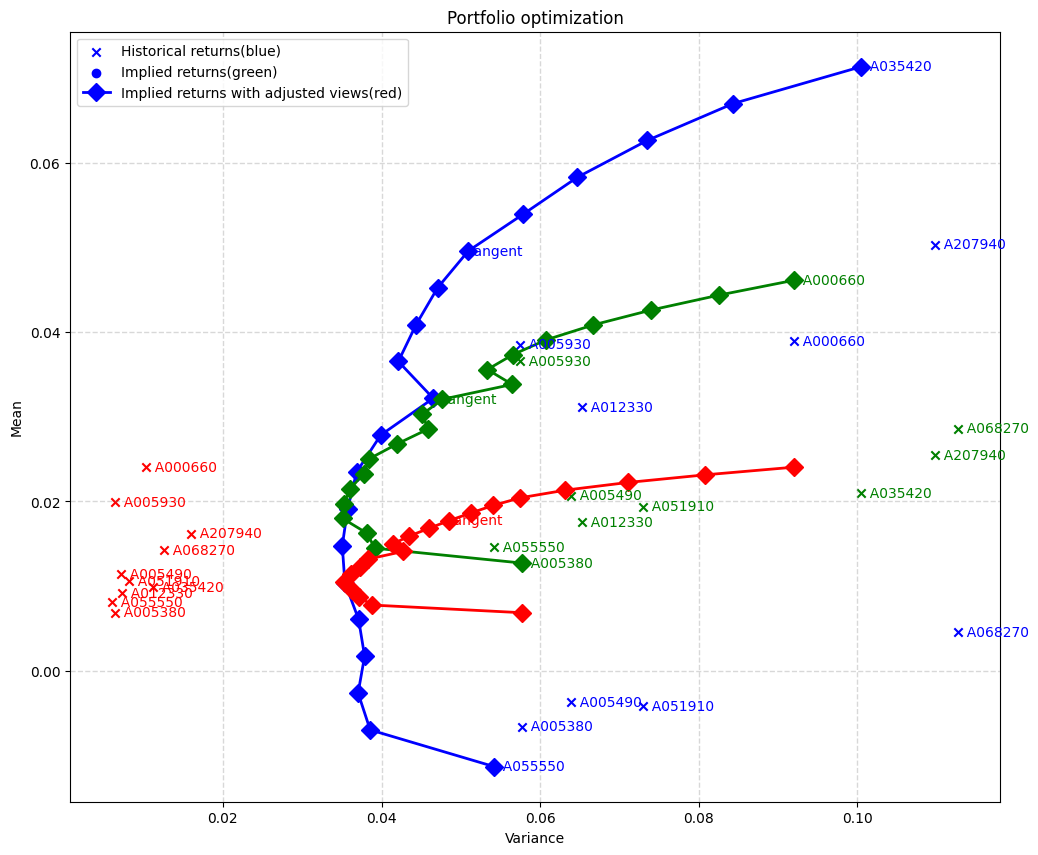

Epoch [1/10], Train Loss: 116.22377586364746, Validation Loss: 12.089824676513672
Epoch [2/10], Train Loss: 115.40704154968262, Validation Loss: 12.052180290222168
Epoch [3/10], Train Loss: 114.71263122558594, Validation Loss: 12.019113540649414
Epoch [4/10], Train Loss: 114.23070240020752, Validation Loss: 11.985097885131836
Epoch [5/10], Train Loss: 113.60678005218506, Validation Loss: 11.944823265075684
Epoch [6/10], Train Loss: 112.92460060119629, Validation Loss: 11.896628379821777
Epoch [7/10], Train Loss: 112.33686065673828, Validation Loss: 11.836840629577637
Epoch [8/10], Train Loss: 111.61493682861328, Validation Loss: 11.765685081481934
Epoch [9/10], Train Loss: 110.70446586608887, Validation Loss: 11.679985046386719
Epoch [10/10], Train Loss: 109.8019027709961, Validation Loss: 11.576693534851074
Epoch [1/10], Train Loss: 117.12334251403809, Validation Loss: 13.3478364944458
Epoch [2/10], Train Loss: 115.94654273986816, Validation Loss: 13.231554985046387
Epoch [3/10], Trai

/tmp/ipykernel_2819358/393526100.py:80: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


2019-12-16 00:00:00,A005930,A000660,A035420,A207940,A005380,A012330,A068270,A051910,A005490,A055550
Weight,22.86%,21.12%,46.01%,9.69%,0.00%,0.32%,0.00%,0.00%,0.00%,0.00%


2019-12-16 00:00:00,A005930,A000660,A035420,A207940,A005380,A012330,A068270,A051910,A005490,A055550
Weight,56.02%,11.07%,5.08%,4.48%,4.35%,4.26%,3.75%,3.75%,3.63%,3.61%


2019-12-16 00:00:00,A005930,A000660,A035420,A207940,A005380,A012330,A068270,A051910,A005490,A055550
Weight,80.75%,0.38%,5.92%,2.25%,0.00%,2.10%,0.00%,0.00%,8.60%,0.00%


/tmp/ipykernel_2819358/2353691125.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color)


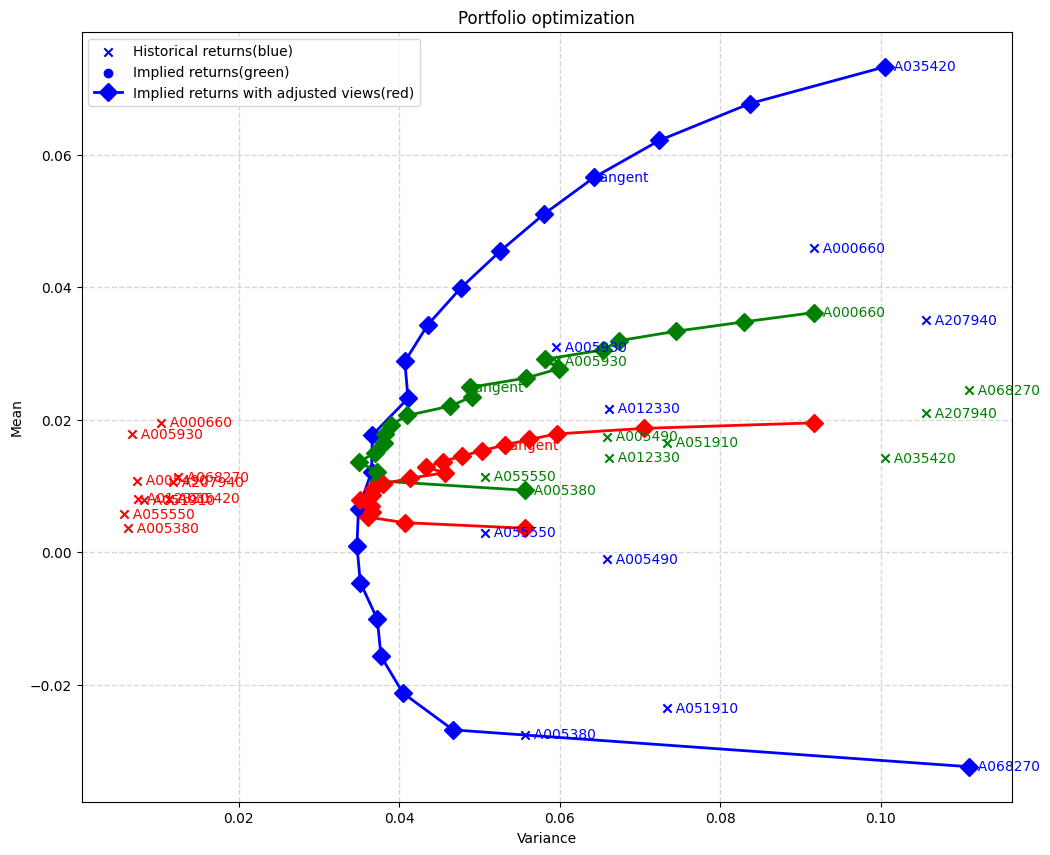

Epoch [1/10], Train Loss: 116.42840099334717, Validation Loss: 15.569347381591797
Epoch [2/10], Train Loss: 115.5696382522583, Validation Loss: 15.593913078308105
Epoch [3/10], Train Loss: 115.15267658233643, Validation Loss: 15.627176284790039
Epoch [4/10], Train Loss: 114.60640335083008, Validation Loss: 15.655795097351074
Epoch [5/10], Train Loss: 114.15636920928955, Validation Loss: 15.672500610351562
Epoch [6/10], Train Loss: 113.78978824615479, Validation Loss: 15.67552661895752
Epoch [7/10], Train Loss: 113.17259216308594, Validation Loss: 15.662917137145996
Epoch [8/10], Train Loss: 112.71121406555176, Validation Loss: 15.626220703125
Epoch [9/10], Train Loss: 112.01134204864502, Validation Loss: 15.571043968200684
Epoch [10/10], Train Loss: 111.02072238922119, Validation Loss: 15.498178482055664
Epoch [1/10], Train Loss: 116.19929218292236, Validation Loss: 16.44574546813965
Epoch [2/10], Train Loss: 115.4007396697998, Validation Loss: 16.383264541625977
Epoch [3/10], Train Lo

/tmp/ipykernel_2819358/393526100.py:80: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


2020-01-16 00:00:00,A005930,A000660,A035420,A207940,A005380,A068270,A012330,A051910,A051900,A005490
Weight,39.07%,0.00%,36.40%,21.66%,0.00%,0.00%,0.00%,0.00%,2.87%,0.00%


2020-01-16 00:00:00,A005930,A000660,A035420,A207940,A005380,A068270,A012330,A051910,A051900,A005490
Weight,57.09%,11.37%,4.99%,4.57%,3.99%,3.82%,3.74%,3.63%,3.48%,3.32%


2020-01-16 00:00:00,A005930,A000660,A035420,A207940,A005380,A068270,A012330,A051910,A051900,A005490
Weight,60.46%,11.85%,7.50%,3.47%,2.33%,3.76%,0.00%,5.12%,4.25%,1.26%


/tmp/ipykernel_2819358/2353691125.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color)


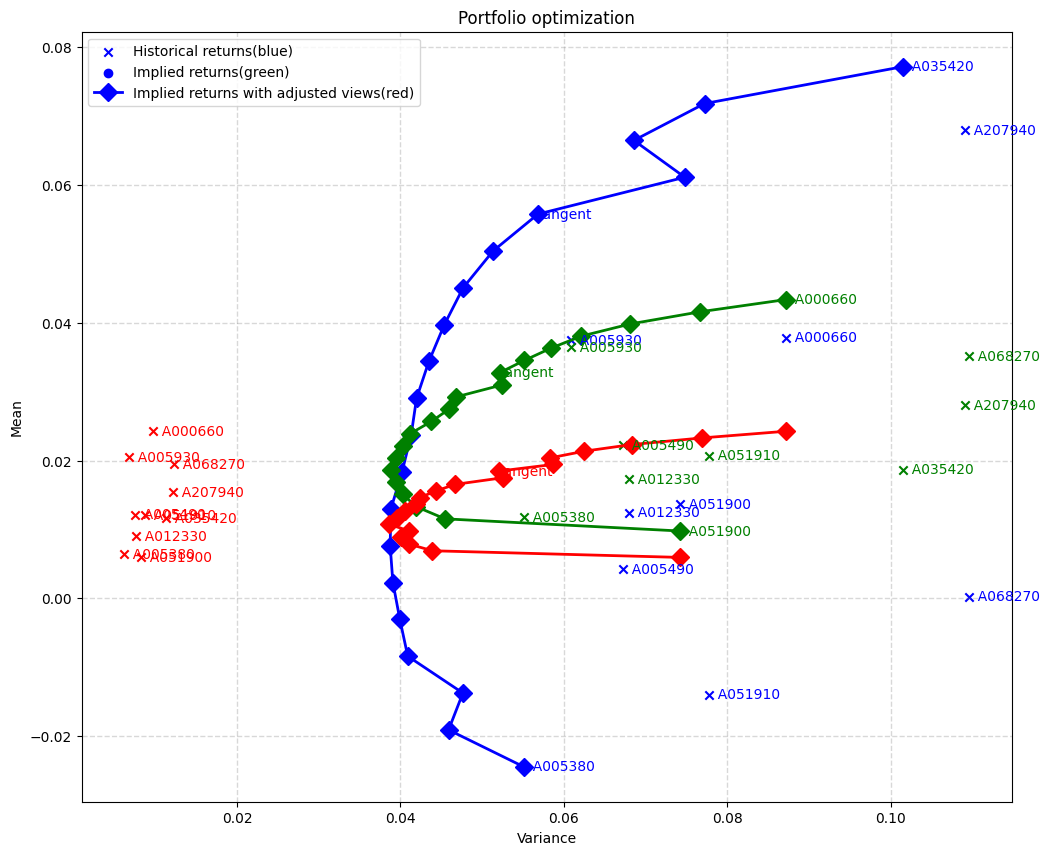

Epoch [1/10], Train Loss: 112.00910091400146, Validation Loss: 20.483821868896484
Epoch [2/10], Train Loss: 111.2994384765625, Validation Loss: 20.394596099853516
Epoch [3/10], Train Loss: 110.73546886444092, Validation Loss: 20.3187198638916
Epoch [4/10], Train Loss: 110.11547470092773, Validation Loss: 20.250337600708008
Epoch [5/10], Train Loss: 109.66459369659424, Validation Loss: 20.18338394165039
Epoch [6/10], Train Loss: 108.94356441497803, Validation Loss: 20.12029457092285
Epoch [7/10], Train Loss: 108.25098896026611, Validation Loss: 20.061519622802734
Epoch [8/10], Train Loss: 107.33924770355225, Validation Loss: 20.005971908569336
Epoch [9/10], Train Loss: 106.70821189880371, Validation Loss: 19.950096130371094
Epoch [10/10], Train Loss: 105.54023742675781, Validation Loss: 19.89631462097168
Epoch [1/10], Train Loss: 115.72919368743896, Validation Loss: 14.628780364990234
Epoch [2/10], Train Loss: 114.94097709655762, Validation Loss: 14.579947471618652
Epoch [3/10], Train L

/tmp/ipykernel_2819358/393526100.py:80: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


2020-02-17 00:00:00,A005930,A000660,A207940,A035420,A051910,A005380,A068270,A006400,A012330,A028260
Weight,47.33%,0.00%,41.18%,8.18%,0.00%,0.00%,0.00%,3.31%,0.00%,0.00%


2020-02-17 00:00:00,A005930,A000660,A207940,A035420,A051910,A005380,A068270,A006400,A012330,A028260
Weight,55.52%,11.56%,5.20%,4.70%,4.47%,4.37%,3.79%,3.52%,3.45%,3.43%


2020-02-17 00:00:00,A005930,A000660,A207940,A035420,A051910,A005380,A068270,A006400,A012330,A028260
Weight,55.51%,10.48%,6.43%,3.70%,7.18%,4.73%,2.94%,4.05%,4.98%,0.00%


/tmp/ipykernel_2819358/2353691125.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color)


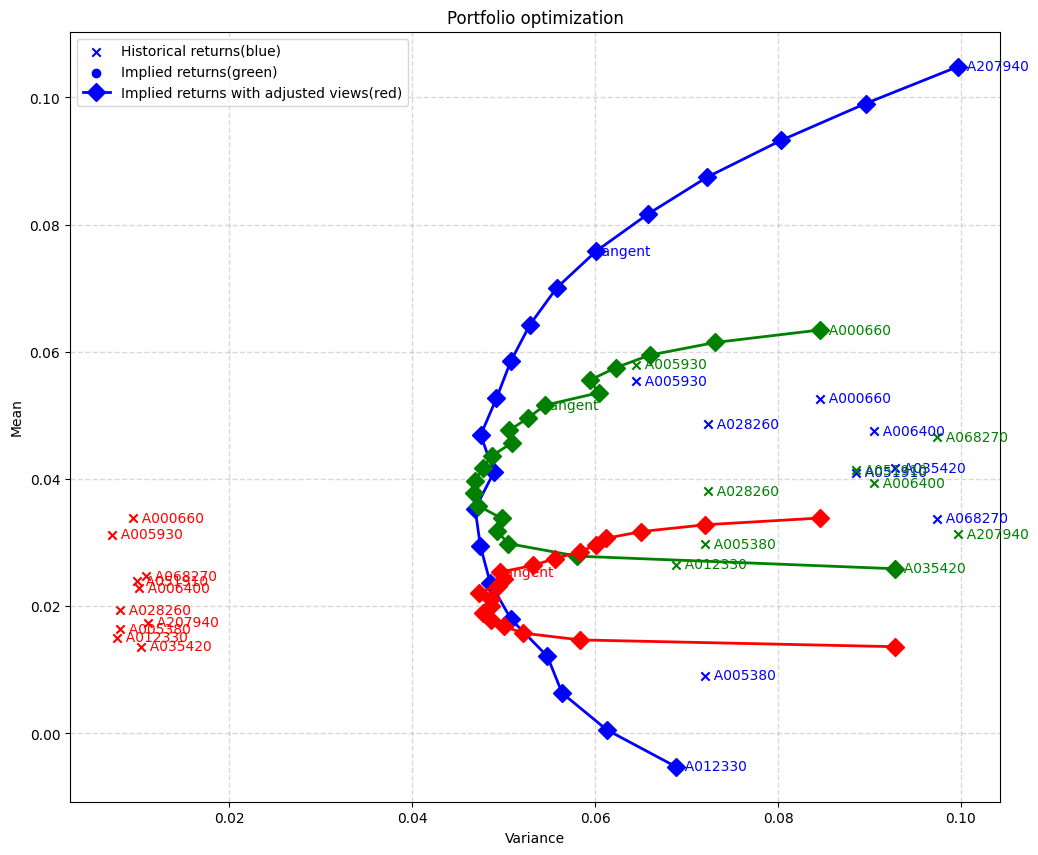

Epoch [1/10], Train Loss: 112.3002700805664, Validation Loss: 21.09684181213379
Epoch [2/10], Train Loss: 111.56320381164551, Validation Loss: 21.074607849121094
Epoch [3/10], Train Loss: 111.14480876922607, Validation Loss: 21.049428939819336
Epoch [4/10], Train Loss: 110.50284767150879, Validation Loss: 21.019681930541992
Epoch [5/10], Train Loss: 110.02632713317871, Validation Loss: 20.987102508544922
Epoch [6/10], Train Loss: 109.20696926116943, Validation Loss: 20.95037269592285
Epoch [7/10], Train Loss: 108.56456756591797, Validation Loss: 20.905860900878906
Epoch [8/10], Train Loss: 107.7347936630249, Validation Loss: 20.858476638793945
Epoch [9/10], Train Loss: 106.9946060180664, Validation Loss: 20.808252334594727
Epoch [10/10], Train Loss: 105.84378433227539, Validation Loss: 20.754053115844727
Epoch [1/10], Train Loss: 116.97992324829102, Validation Loss: 17.584199905395508
Epoch [2/10], Train Loss: 115.89539432525635, Validation Loss: 17.534128189086914
Epoch [3/10], Train 

In [171]:
rf = 0.015/250*20

### for문 한번마다 120일 자산 배분
for index, names in stock_mkcap_top10.iterrows():
    views = []
    date_str = '2018-09-27 00:00:00'
    parsed_datetime = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")

    if index < parsed_datetime:
        continue
        
    # 로그리턴 구하기
    row_num = stock_price.index.get_loc(index)    
    stock_price_top10 = stock_price.iloc[row_num-120:row_num, :]
    
    stock_price_top10 = stock_price_top10[names]    
    log_return = np.log(stock_price_top10 / stock_price_top10.shift(1))[1:]
    R = log_return.mean() * 20

    # 공분산 구하기
    C = np.cov(log_return, rowvar=False) * 20
    
    # 시가총액 weight 구하기
    mkcap = stock_mkcap.loc[index, names]
    W = mkcap / sum(mkcap)

    # View Distribution 구하기    
    stock_price_hist = stock_price.iloc[row_num-1200:row_num, :]
    stock_price_hist = stock_price_hist[names]    
    columns = stock_price_hist.columns
    
    ### TCN 훈련을 통한 뷰벡터 만들기
    views = train_tcn(stock_price_hist, views)
    
    ### 또는 훈련된 뷰벡터 가져오기
    """
    for time_step in view_tot:
        if index == time_step[0]:
            views = time_step[1]
            break
    """        
            
    ### MV 최적화
    opt1 = optimize_frontier(R, C, rf)

    ### 블랙-리터만 역최적화
    # 포트폴리오 수익률 평균 및 분산
    mean = sum(R * W)
    var = np.dot(np.dot(W, C), W)

    # 위험회피계수
    lmbda = (mean - rf) / var  

    # 균형초과수익률
    pi = np.dot(np.dot(lmbda, C), W)
    
    # 균형기대수익률로 최적화
    opt2 = optimize_frontier(pi, C, rf)
    
    # 투자자 전망과 기대수익률ㄹ 그리고 전망의 불확실성 계산
    Q, P = CreateMatrixPQ(columns, views)
    
    # 위험조정상수
    tau = .025  

    # 투자자 전망의 불확실성 계산
    # tau * P * C * transpose(P)
    omega = np.dot(np.dot(np.dot(tau, P), C), np.transpose(P))
    
    # 투자자 전망과 합쳐진 균형초과수익률 계산
    bl1 = inv(np.dot(tau, C))
    bl2 = np.dot(np.dot(np.transpose(P), inv(omega)), P)
    bl3 = np.dot(inv(np.dot(tau, C)), pi)
    bl4 = np.dot(np.dot(np.transpose(P), inv(omega)), Q)
    pi_adj = np.dot(inv(bl1 + bl2), (bl3 + bl4))
    cov_update = inv(bl1 + bl2)

    opt3 = optimize_frontier(pi_adj, C, rf)
    
    from IPython.core.display import display, HTML
    pd.options.display.float_format = '{:.2%}'.format

    # 1번째 최적화 결과
    display(HTML('Historical returns'))
    display(pd.DataFrame({'Weight': opt1['weights']}, index=names).T)

    # 2번째 최적화 결과
    display(HTML('Implied returns'))
    display(pd.DataFrame({'Weight': opt2['weights']}, index=names).T)

    # 3번째 최적화 결과
    display(HTML('Implied returns with adjusted views'))
    display(pd.DataFrame({'Weight': opt3['weights']}, index=names).T)
    
    
    # 1번째 최적화 결과를 차트로 출력
    plotAssets(names, R, C, color='blue')
    plotFrontier(opt1, label='Historical returns', color='blue')

    # 2번째 최적화 결과를 차트로 출력
    #plotAssets(names, pi+rf, C, color='green')
    #plotFrontier(opt2, label='Implied returns', color='green')

    # 3번째 최적화 결과를 차트로 출력
    plotAssets(names, pi_adj, C, color='red')
    plotFrontier(opt3, label='Implied returns (adjusted views)', color='red')

    # 차트에 공통된 속성을 지정한다(차트크기, 제목, 범례, 축이름 등)
    plt.rcParams["figure.figsize"] = (12, 10)
    plt.grid(alpha=0.3, color='gray', linestyle='--', linewidth=1)
    plt.title('Portfolio optimization')
    plt.legend(['Historical returns(blue)', 'Implied returns(green)','Implied returns with adjusted views(red)'])
    plt.xlabel('Variance')
    plt.ylabel('Mean')
    plt.show()

# # example
# display(pd.DataFrame({'Return': R, 'Weight':W}, index=names).T)
# display(pd.DataFrame(C, columns=names, index=names))